In [1]:
#Import the required modules
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate, resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Attempt to import the experimental preprocessing module.
try:
    from tensorflow.keras.layers.experimental import preprocessing
except ImportError:
    # If not available, use alternative preprocessing layers.
    # For example, Normalization is available directly under tf.keras.layers.
    print("Experimental preprocessing module not found. Using built-in preprocessing layers instead.")
    from tensorflow.keras.layers import Normalization  # Import other preprocessing layers as needed.



Experimental preprocessing module not found. Using built-in preprocessing layers instead.


Total Patients Found: 285
Selected Patient: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1
Files in patient folder: ['Brats18_2013_10_1_flair.nii', 'Brats18_2013_10_1_seg.nii', 'Brats18_2013_10_1_t1.nii', 'Brats18_2013_10_1_t1ce.nii', 'Brats18_2013_10_1_t2.nii']
Loaded flair from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_flair.nii
Loaded t1 from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1.nii
Loaded t1ce from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii
Loaded t2 from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_t2.nii
Loaded segmentation from C:\Users\kesav\OneDrive\Desktop\FYP\Dat

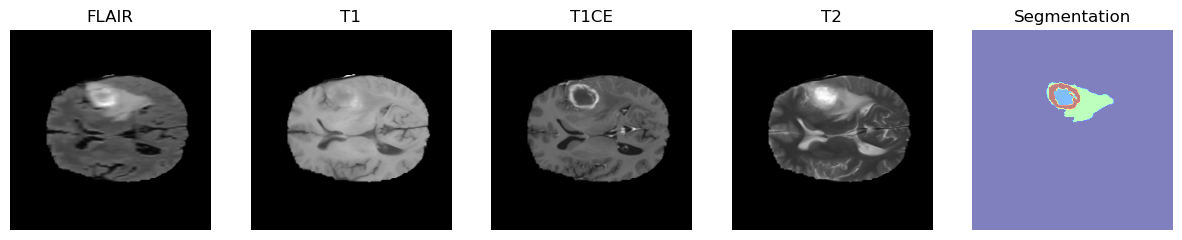

In [2]:
#Data Vsualization
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Set the dataset folder path
dataset_folder = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"

# Initialize a list to store patient folder paths
patient_folders = []

# First, try to locate subfolders named "HGG" and "LGG"
for subfolder in ["HGG", "LGG"]:
    subfolder_path = os.path.join(dataset_folder, subfolder)
    if os.path.exists(subfolder_path):
        for patient in os.listdir(subfolder_path):
            patient_path = os.path.join(subfolder_path, patient)
            if os.path.isdir(patient_path):
                patient_folders.append(patient_path)

# Fallback: If no "HGG" or "LGG" subfolders exist, assume patient folders are directly in the dataset folder
if not patient_folders:
    for patient in os.listdir(dataset_folder):
        patient_path = os.path.join(dataset_folder, patient)
        if os.path.isdir(patient_path):
            patient_folders.append(patient_path)

# Check if any patient folders were found
if not patient_folders:
    raise ValueError("No patient folders found. Please verify the dataset path and directory structure.")

print(f"Total Patients Found: {len(patient_folders)}")

# Select a sample patient (here, the first available patient)
sample_patient = patient_folders[0]
print(f"Selected Patient: {sample_patient}")

# List available files inside the patient folder
available_files = os.listdir(sample_patient)
print("Files in patient folder:", available_files)

# Define the imaging modalities of interest
modalities = ["flair", "t1", "t1ce", "t2"]
images = {}

# Load each modality by dynamically finding the corresponding file (.nii or .nii.gz)
for modality in modalities:
    matching_files = [f for f in available_files if modality in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
    if matching_files:
        modality_path = os.path.join(sample_patient, matching_files[0])
        images[modality] = nib.load(modality_path).get_fdata()
        print(f"Loaded {modality} from {modality_path}")
    else:
        print(f"File not found for modality: {modality}")

# Load the segmentation mask (if available)
segmentation_files = [f for f in available_files if "seg" in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
if segmentation_files:
    segmentation_path = os.path.join(sample_patient, segmentation_files[0])
    segmentation = nib.load(segmentation_path).get_fdata()
    print(f"Loaded segmentation from {segmentation_path}")
else:
    segmentation = None
    print("Segmentation file not found.")

# Ensure that at least one modality image was loaded
if not images:
    raise ValueError("No MRI images were loaded. Please check the file paths.")

# Select a middle slice from one of the modalities (assuming shape: [x, y, z])
slice_idx = list(images.values())[0].shape[2] // 2

# Plot the modalities and segmentation mask (if available)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, modality in enumerate(modalities):
    if modality in images:
        axes[i].imshow(images[modality][:, :, slice_idx], cmap="gray")
        axes[i].set_title(modality.upper())
    else:
        axes[i].set_title(f"{modality.upper()} Not Found")
    axes[i].axis("off")

# Plot the segmentation mask if available
if segmentation is not None:
    axes[4].imshow(segmentation[:, :, slice_idx], cmap="jet", alpha=0.5)
    axes[4].set_title("Segmentation")
    axes[4].axis("off")
else:
    axes[4].set_title("No Segmentation")
    axes[4].axis("off")

plt.show()


Total Patients Found: 335
Selected Patient: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1
Files in patient folder: ['BraTS19_2013_10_1_flair.nii', 'BraTS19_2013_10_1_seg.nii', 'BraTS19_2013_10_1_t1.nii', 'BraTS19_2013_10_1_t1ce.nii', 'BraTS19_2013_10_1_t2.nii']
Loaded flair from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_flair.nii
Loaded t1 from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_t1.nii
Loaded t1ce from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_t1ce.nii
Loaded t2 from C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_20

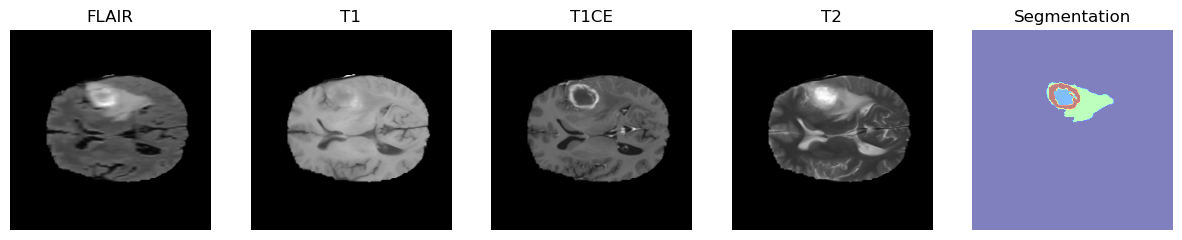

In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Set the dataset folder path (updated for BraTS 2019)
dataset_folder = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training"

# Initialize a list to store patient folder paths
patient_folders = []

# First, try to locate subfolders named "HGG" and "LGG"
for subfolder in ["HGG", "LGG"]:
    subfolder_path = os.path.join(dataset_folder, subfolder)
    if os.path.exists(subfolder_path):
        for patient in os.listdir(subfolder_path):
            patient_path = os.path.join(subfolder_path, patient)
            if os.path.isdir(patient_path):
                patient_folders.append(patient_path)

# Fallback: If no "HGG" or "LGG" subfolders exist, assume patient folders are directly in the dataset folder
if not patient_folders:
    for patient in os.listdir(dataset_folder):
        patient_path = os.path.join(dataset_folder, patient)
        if os.path.isdir(patient_path):
            patient_folders.append(patient_path)

# Check if any patient folders were found
if not patient_folders:
    raise ValueError("No patient folders found. Please verify the dataset path and directory structure.")

print(f"Total Patients Found: {len(patient_folders)}")

# Select a sample patient (here, the first available patient)
sample_patient = patient_folders[0]
print(f"Selected Patient: {sample_patient}")

# List available files inside the patient folder
available_files = os.listdir(sample_patient)
print("Files in patient folder:", available_files)

# Define the imaging modalities of interest
modalities = ["flair", "t1", "t1ce", "t2"]
images = {}

# Load each modality by dynamically finding the corresponding file (.nii or .nii.gz)
for modality in modalities:
    matching_files = [f for f in available_files if modality in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
    if matching_files:
        modality_path = os.path.join(sample_patient, matching_files[0])
        images[modality] = nib.load(modality_path).get_fdata()
        print(f"Loaded {modality} from {modality_path}")
    else:
        print(f"File not found for modality: {modality}")

# Load the segmentation mask (if available)
segmentation_files = [f for f in available_files if "seg" in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
if segmentation_files:
    segmentation_path = os.path.join(sample_patient, segmentation_files[0])
    segmentation = nib.load(segmentation_path).get_fdata()
    print(f"Loaded segmentation from {segmentation_path}")
else:
    segmentation = None
    print("Segmentation file not found.")

# Ensure that at least one modality image was loaded
if not images:
    raise ValueError("No MRI images were loaded. Please check the file paths.")

# Select a middle slice from one of the modalities (assuming shape: [x, y, z])
slice_idx = list(images.values())[0].shape[2] // 2

# Plot the modalities and segmentation mask (if available)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, modality in enumerate(modalities):
    if modality in images:
        axes[i].imshow(images[modality][:, :, slice_idx], cmap="gray")
        axes[i].set_title(modality.upper())
    else:
        axes[i].set_title(f"{modality.upper()} Not Found")
    axes[i].axis("off")

# Plot the segmentation mask if available
if segmentation is not None:
    axes[4].imshow(segmentation[:, :, slice_idx], cmap="jet", alpha=0.5)
    axes[4].set_title("Segmentation")
    axes[4].axis("off")
else:
    axes[4].set_title("No Segmentation")
    axes[4].axis("off")

plt.show()


In [4]:
import os

def count_patient_folders(dataset_folder):
    """
    Count patient folders in the given dataset folder.
    First, the function tries to find subfolders "HGG" and "LGG".
    If they are not found, it assumes that patient folders are directly under the dataset folder.
    """
    patient_folders = []

    # Look for subfolders "HGG" and "LGG"
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)

    # Fallback: If no subfolders found, consider the dataset folder directly
    if not patient_folders:
        for patient in os.listdir(dataset_folder):
            patient_path = os.path.join(dataset_folder, patient)
            if os.path.isdir(patient_path):
                patient_folders.append(patient_path)

    return patient_folders

# Define dataset paths
dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"
dataset_folder_2019 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training"

# Count patient folders for each dataset
patient_folders_2018 = count_patient_folders(dataset_folder_2018)
patient_folders_2019 = count_patient_folders(dataset_folder_2019)

# Get counts
count_2018 = len(patient_folders_2018)
count_2019 = len(patient_folders_2019)
total_count = count_2018 + count_2019

# Print the counts
print(f"BraTS 2018 Patient Folders: {count_2018}")
print(f"BraTS 2019 Patient Folders: {count_2019}")
print(f"Total Patient Folders: {total_count}")


BraTS 2018 Patient Folders: 285
BraTS 2019 Patient Folders: 335
Total Patient Folders: 620


Total patient folders in C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training: 285
Selected Patient: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1
Files in patient folder: ['Brats18_2013_10_1_flair.nii', 'Brats18_2013_10_1_seg.nii', 'Brats18_2013_10_1_t1.nii', 'Brats18_2013_10_1_t1ce.nii', 'Brats18_2013_10_1_t2.nii']
Processing file for modality 'flair': C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_flair.nii
Original image shape for flair: (240, 240, 155)
Z-score normalization applied for flair.

Processing file for modality 't1': C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1.nii
Original image shape for t1: (240, 240, 155)
Z-score normalization applied for t1.

Processing file for modality 't1ce': C:\Users\kesav\OneDrive\D

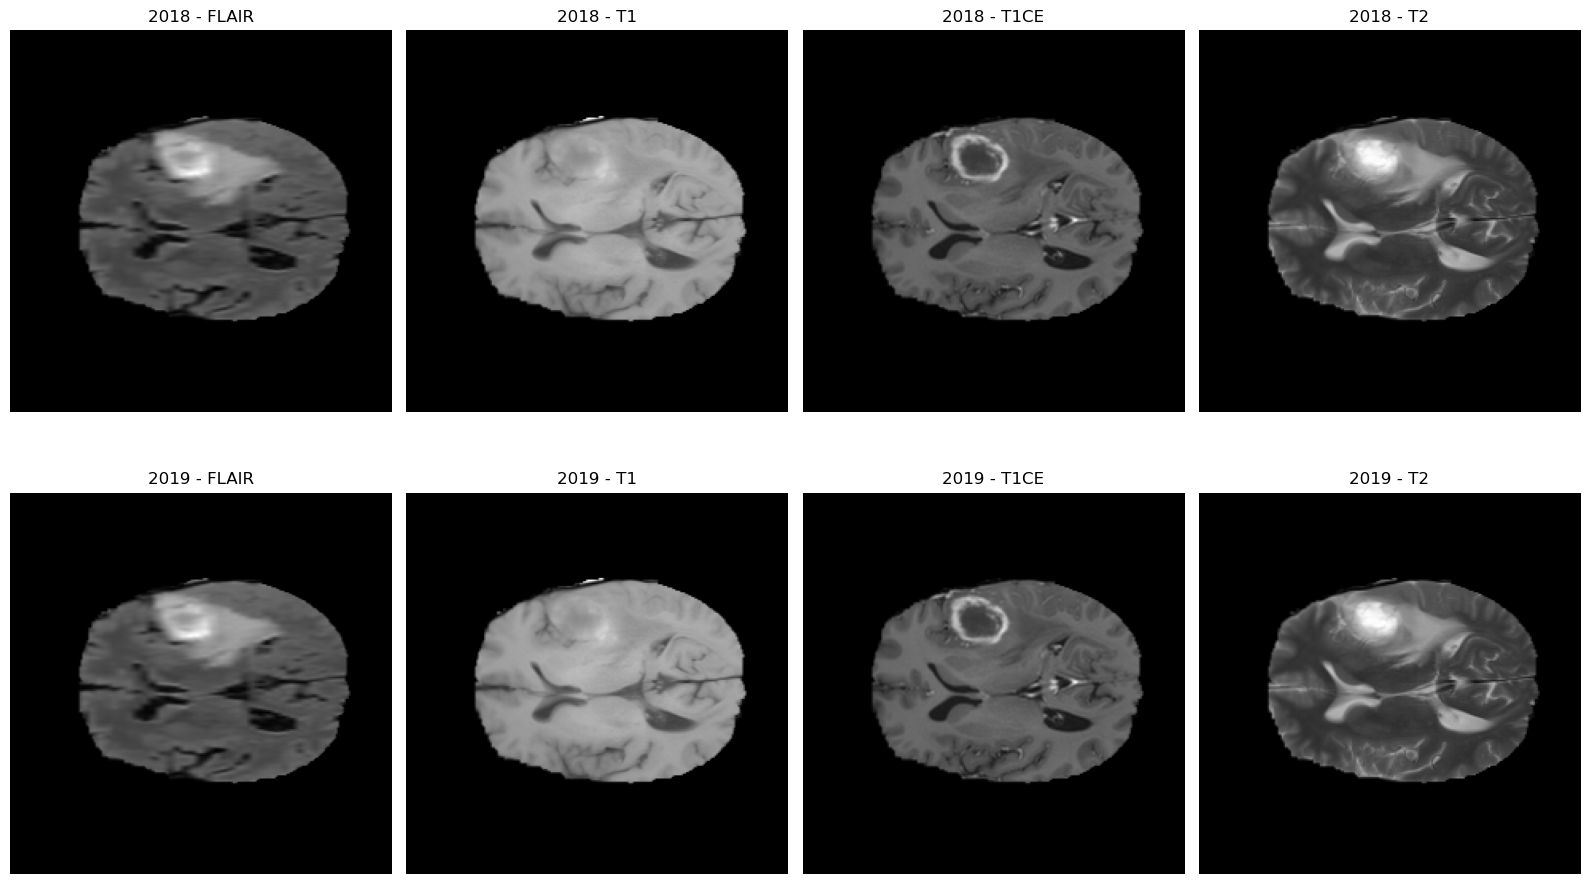

In [5]:
#Normalization
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def zscore_normalize(image):
    """
    Applies Z-score normalization to the input image.
    
    Parameters:
        image (np.ndarray): The input image data.
        
    Returns:
        np.ndarray: The normalized image.
    """
    mean = np.mean(image)
    std = np.std(image)
    if std == 0:
        raise ValueError("Standard deviation is zero, normalization is not possible.")
    return (image - mean) / std

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It first looks for "HGG" and "LGG" subdirectories; if none are found,
    it considers folders directly under the dataset folder.
    """
    patient_folders = []
    
    # Look for subfolders "HGG" and "LGG"
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
                    
    # Fallback: If no subfolders found, consider the dataset folder directly
    if not patient_folders:
        for patient in os.listdir(dataset_folder):
            patient_path = os.path.join(dataset_folder, patient)
            if os.path.isdir(patient_path):
                patient_folders.append(patient_path)
                
    return patient_folders

def process_dataset_all(dataset_folder, modalities=["flair", "t1", "t1ce", "t2"]):
    """
    Processes a given dataset folder by:
      - Finding patient folders.
      - Selecting a sample patient.
      - Loading each specified modality image.
      - Applying Z-score normalization.
      
    Returns a dictionary mapping modality names to a dictionary containing:
      - 'data': normalized image data,
      - 'affine': image affine,
      - 'header': image header.
    """
    # Retrieve patient folders
    patient_folders = get_patient_folders(dataset_folder)
    if not patient_folders:
        raise ValueError(f"No patient folders found in {dataset_folder}")
    
    print(f"Total patient folders in {dataset_folder}: {len(patient_folders)}")
    
    # Select a sample patient (first available)
    sample_patient = patient_folders[0]
    print("Selected Patient:", sample_patient)
    
    # List files in the sample patient folder
    available_files = os.listdir(sample_patient)
    print("Files in patient folder:", available_files)
    
    normalized_images = {}
    for modality in modalities:
        # Locate the file for the specified modality (supports both .nii and .nii.gz)
        matching_files = [f for f in available_files 
                          if modality in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
        if not matching_files:
            print(f"No file found for modality '{modality}' in {sample_patient}")
            continue
        
        modality_path = os.path.join(sample_patient, matching_files[0])
        print(f"Processing file for modality '{modality}':", modality_path)
        
        # Load the image using nibabel
        image_nifti = nib.load(modality_path)
        image_data = image_nifti.get_fdata()
        print(f"Original image shape for {modality}: {image_data.shape}")
        
        # Apply Z-score normalization
        normalized_images[modality] = {
            'data': zscore_normalize(image_data),
            'affine': image_nifti.affine,
            'header': image_nifti.header
        }
        print(f"Z-score normalization applied for {modality}.\n")
    
    return normalized_images

# Dataset folder paths for BraTS 2018 and BraTS 2019
dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"
dataset_folder_2019 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training"

modalities = ["flair", "t1", "t1ce", "t2"]

# Process both datasets for all modalities (everything stays in memory)
normalized_images_2018 = process_dataset_all(dataset_folder_2018, modalities)
normalized_images_2019 = process_dataset_all(dataset_folder_2019, modalities)

# Visualize the middle slice from each normalized image for both datasets
num_modalities = len(modalities)
fig, axes = plt.subplots(2, num_modalities, figsize=(4 * num_modalities, 10))  # 2 rows: one per dataset

for i, modality in enumerate(modalities):
    # BraTS 2018 row
    if modality in normalized_images_2018:
        image_2018 = normalized_images_2018[modality]['data']
        slice_idx = image_2018.shape[2] // 2
        axes[0, i].imshow(image_2018[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f"2018 - {modality.upper()}")
    else:
        axes[0, i].set_title(f"2018 - {modality.upper()} Not Found")
    axes[0, i].axis("off")
    
    # BraTS 2019 row
    if modality in normalized_images_2019:
        image_2019 = normalized_images_2019[modality]['data']
        slice_idx = image_2019.shape[2] // 2
        axes[1, i].imshow(image_2019[:, :, slice_idx], cmap='gray')
        axes[1, i].set_title(f"2019 - {modality.upper()}")
    else:
        axes[1, i].set_title(f"2019 - {modality.upper()} Not Found")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


Found 285 patient folders in C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training
Processed FLAIR for patient Brats18_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1 for patient Brats18_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1CE for patient Brats18_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T2 for patient Brats18_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed FLAIR for patient Brats18_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1 for patient Brats18_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1CE for patient Brats18_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T2 for patient Brats18_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed FLAIR for patient Brats18_2013_12_1: original (240, 240, 155) -> resized (128, 128, 128)
Proces

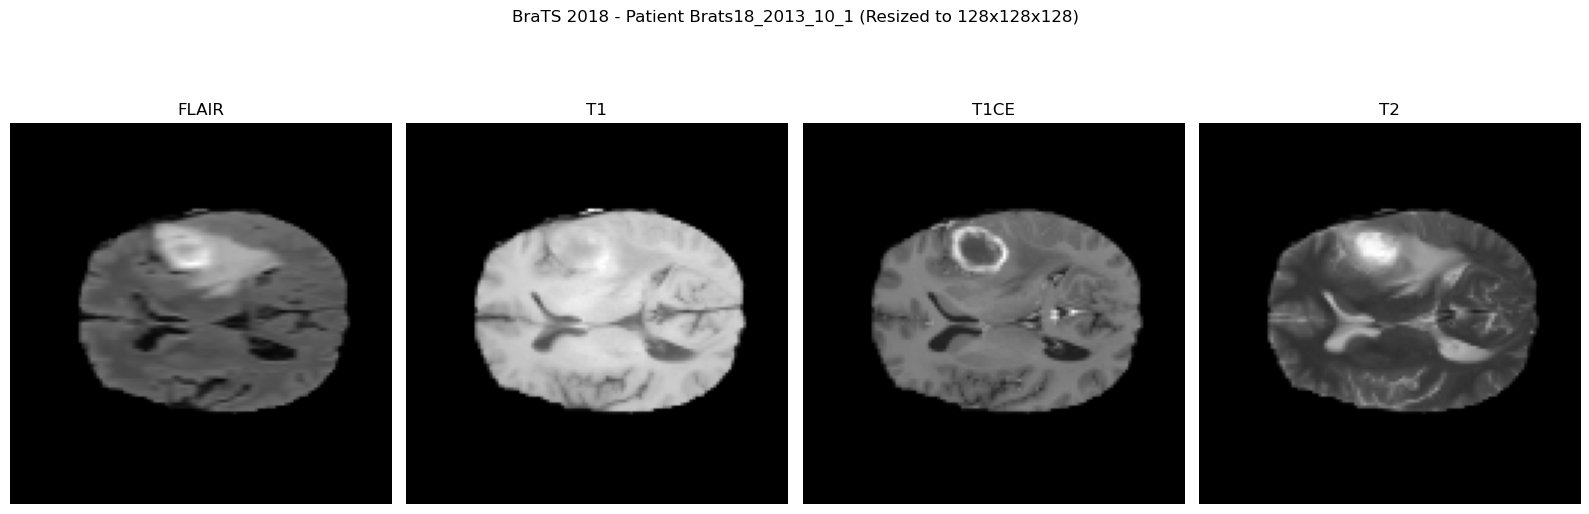

In [14]:
#Resizing
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It first looks for "HGG" and "LGG" subdirectories; if none are found,
    it considers folders directly under the dataset folder.
    """
    patient_folders = []
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    if not patient_folders:
        for patient in os.listdir(dataset_folder):
            patient_path = os.path.join(dataset_folder, patient)
            if os.path.isdir(patient_path):
                patient_folders.append(patient_path)
    return patient_folders

def resize_image(image, target_shape=(128, 128, 128)):
    """
    Resizes a 3D image to the target shape.
    
    Parameters:
        image (np.ndarray): The input 3D image.
        target_shape (tuple): Desired output shape.
        
    Returns:
        np.ndarray: The resized image.
    """
    # Disable anti_aliasing to reduce memory usage
    return resize(image, target_shape, mode='constant', anti_aliasing=False)

def process_patient(patient_folder, modalities=["flair", "t1", "t1ce", "t2"], target_shape=(128,128,128)):
    """
    Processes one patient by loading and resizing each specified modality.
    
    Returns:
        tuple: (patient_id, dict) mapping modality names to resized images.
    """
    patient_id = os.path.basename(patient_folder)
    patient_results = {}
    files = os.listdir(patient_folder)
    
    for modality in modalities:
        matching_files = [f for f in files if modality in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
        if matching_files:
            modality_path = os.path.join(patient_folder, matching_files[0])
            try:
                image_nifti = nib.load(modality_path)
                image_data = image_nifti.get_fdata()
                resized_image = resize_image(image_data, target_shape)
                patient_results[modality] = resized_image
                print(f"Processed {modality.upper()} for patient {patient_id}: original {image_data.shape} -> resized {resized_image.shape}")
            except Exception as e:
                print(f"Error processing {modality.upper()} for patient {patient_id}: {e}")
                patient_results[modality] = None
        else:
            print(f"{modality.upper()} not found for patient {patient_id}")
            patient_results[modality] = None
    return patient_id, patient_results

if __name__ == '__main__':
    # Define the BraTS 2018 dataset folder path
    dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"
    
    # Get all patient folders
    patient_folders = get_patient_folders(dataset_folder_2018)
    print(f"Found {len(patient_folders)} patient folders in {dataset_folder_2018}")
    
    # Process each patient sequentially
    resized_results_2018 = {}
    for folder in patient_folders:
        try:
            patient_id, patient_data = process_patient(folder, modalities=["flair", "t1", "t1ce", "t2"], target_shape=(128,128,128))
            resized_results_2018[patient_id] = patient_data
        except Exception as e:
            print(f"Error processing patient in folder {folder}: {e}")
    
    # Example visualization: Display the middle slice of each modality for one sample patient
    sample_patient = next(iter(resized_results_2018))  # Get the first patient ID
    sample_data = resized_results_2018[sample_patient]
    modalities = ["flair", "t1", "t1ce", "t2"]
    num_modalities = len(modalities)
    
    fig, axes = plt.subplots(1, num_modalities, figsize=(4 * num_modalities, 6))
    for i, modality in enumerate(modalities):
        modality_img = sample_data.get(modality)
        if modality_img is not None:
            slice_idx = modality_img.shape[2] // 2
            axes[i].imshow(modality_img[:, :, slice_idx], cmap='gray')
            axes[i].set_title(modality.upper())
        else:
            axes[i].text(0.5, 0.5, f"No {modality.upper()}",
                         horizontalalignment='center', verticalalignment='center')
            axes[i].set_title(modality.upper())
        axes[i].axis("off")
    
    plt.suptitle(f"BraTS 2018 - Patient {sample_patient} (Resized to 128x128x128)")
    plt.tight_layout()
    plt.show()


Found 335 patient folders in C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training
Processed FLAIR for patient BraTS19_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1 for patient BraTS19_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1CE for patient BraTS19_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T2 for patient BraTS19_2013_10_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed FLAIR for patient BraTS19_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1 for patient BraTS19_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T1CE for patient BraTS19_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed T2 for patient BraTS19_2013_11_1: original (240, 240, 155) -> resized (128, 128, 128)
Processed FLAIR for patient BraTS19_2013_12_1: original (240, 240, 155) -

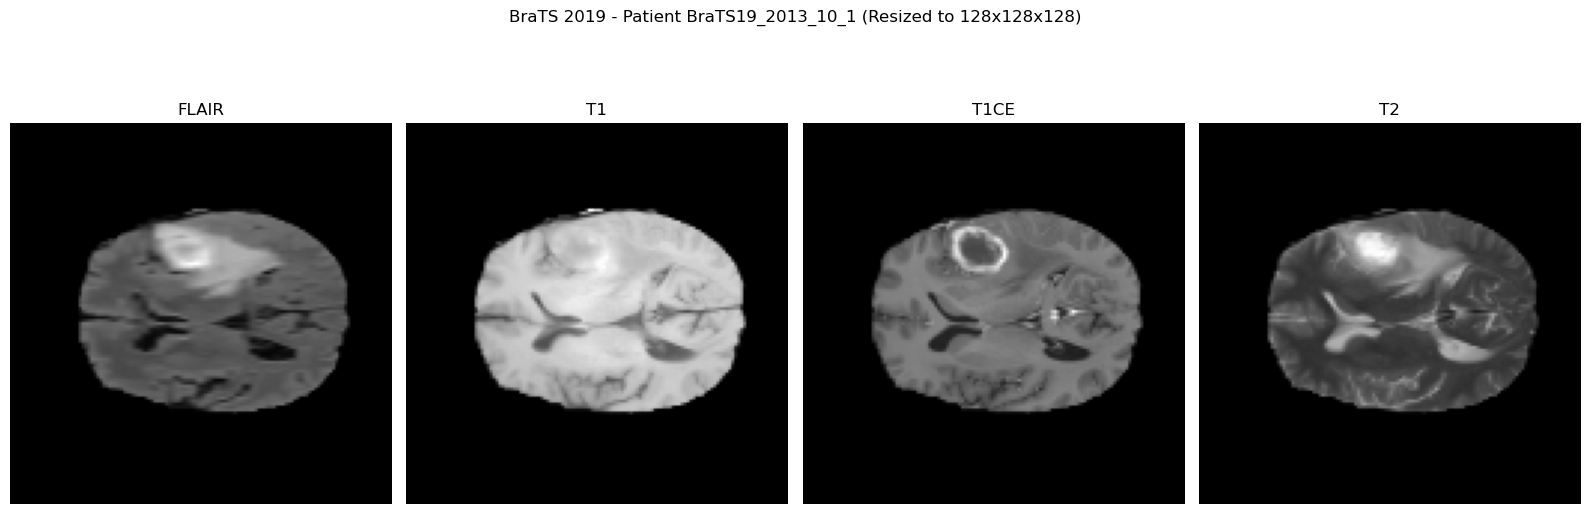

In [9]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It first looks for "HGG" and "LGG" subdirectories; if none are found,
    it considers folders directly under the dataset folder.
    """
    patient_folders = []
    # Look for subfolders "HGG" and "LGG"
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    # Fallback: If no subfolders found, consider the dataset folder directly
    if not patient_folders:
        for patient in os.listdir(dataset_folder):
            patient_path = os.path.join(dataset_folder, patient)
            if os.path.isdir(patient_path):
                patient_folders.append(patient_path)
    return patient_folders

def resize_image(image, target_shape=(128, 128, 128)):
    """
    Resizes a 3D image to the target shape.
    
    Parameters:
        image (np.ndarray): The input 3D image.
        target_shape (tuple): Desired output shape.
        
    Returns:
        np.ndarray: The resized image.
    """
    # Disable anti_aliasing to reduce memory usage
    return resize(image, target_shape, mode='constant', anti_aliasing=False)

def process_patient(patient_folder, modalities=["flair", "t1", "t1ce", "t2"], target_shape=(128,128,128)):
    """
    Processes one patient by loading and resizing each specified modality.
    
    Returns:
        tuple: (patient_id, dict) mapping modality names to resized images.
    """
    patient_id = os.path.basename(patient_folder)
    patient_results = {}
    files = os.listdir(patient_folder)
    
    for modality in modalities:
        matching_files = [f for f in files if modality in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
        if matching_files:
            modality_path = os.path.join(patient_folder, matching_files[0])
            try:
                image_nifti = nib.load(modality_path)
                image_data = image_nifti.get_fdata()
                resized_image = resize_image(image_data, target_shape)
                patient_results[modality] = resized_image
                print(f"Processed {modality.upper()} for patient {patient_id}: original {image_data.shape} -> resized {resized_image.shape}")
            except Exception as e:
                print(f"Error processing {modality.upper()} for patient {patient_id}: {e}")
                patient_results[modality] = None
        else:
            print(f"{modality.upper()} not found for patient {patient_id}")
            patient_results[modality] = None
    return patient_id, patient_results

if __name__ == '__main__':
    # Define the BraTS 2019 dataset folder path
    dataset_folder_2019 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training"
    
    # Get all patient folders from the BraTS 2019 dataset
    patient_folders = get_patient_folders(dataset_folder_2019)
    print(f"Found {len(patient_folders)} patient folders in {dataset_folder_2019}")
    
    # Process each patient sequentially
    resized_results_2019 = {}
    for folder in patient_folders:
        try:
            patient_id, patient_data = process_patient(folder, modalities=["flair", "t1", "t1ce", "t2"], target_shape=(128,128,128))
            resized_results_2019[patient_id] = patient_data
        except Exception as e:
            print(f"Error processing patient in folder {folder}: {e}")
    
    # Example visualization: Display the middle slice of each modality for one sample patient
    sample_patient = next(iter(resized_results_2019))  # Get the first patient ID
    sample_data = resized_results_2019[sample_patient]
    modalities = ["flair", "t1", "t1ce", "t2"]
    num_modalities = len(modalities)
    
    fig, axes = plt.subplots(1, num_modalities, figsize=(4 * num_modalities, 6))
    for i, modality in enumerate(modalities):
        modality_img = sample_data.get(modality)
        if modality_img is not None:
            slice_idx = modality_img.shape[2] // 2
            axes[i].imshow(modality_img[:, :, slice_idx], cmap='gray')
            axes[i].set_title(modality.upper())
        else:
            axes[i].text(0.5, 0.5, f"No {modality.upper()}",
                         horizontalalignment='center', verticalalignment='center')
            axes[i].set_title(modality.upper())
        axes[i].axis("off")
    
    plt.suptitle(f"BraTS 2019 - Patient {sample_patient} (Resized to 128x128x128)")
    plt.tight_layout()
    plt.show()


Using patient folder: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1
Using T1ce file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_10_1\BraTS19_2013_10_1_t1ce.nii
Using slice index: 77


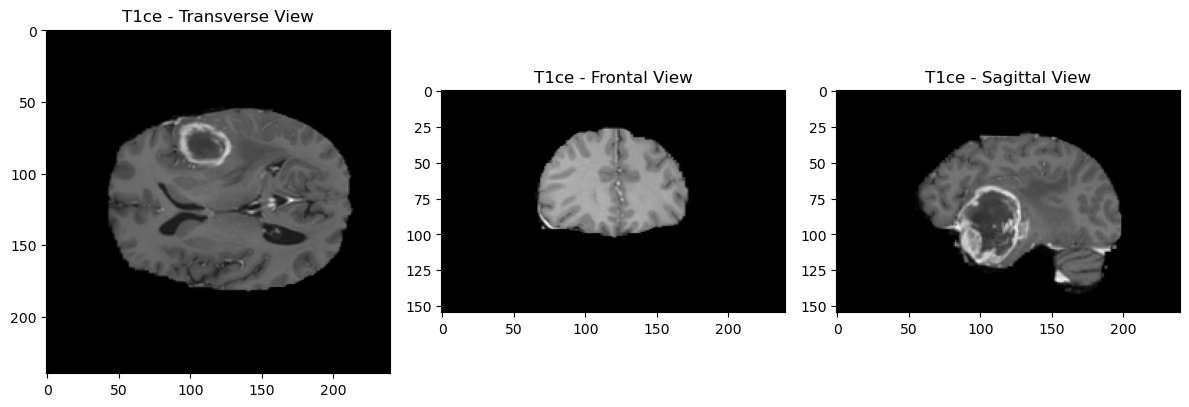

In [25]:
#Orthogonal Views
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate

# Define the BraTS 2019 dataset folder path
dataset_folder_2019 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training"

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It first looks for "HGG" and "LGG" subdirectories; if none are found,
    it considers folders directly under the dataset folder.
    """
    patient_folders = []
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    return patient_folders

# Get list of patient folders
patient_folders = get_patient_folders(dataset_folder_2019)
if not patient_folders:
    raise Exception("No patient folders found in the BraTS 2019 dataset.")

# Choose a sample patient folder (first one)
sample_patient_folder = patient_folders[0]
print("Using patient folder:", sample_patient_folder)

# Locate the T1ce file inside the sample patient folder
t1ce_files = [f for f in os.listdir(sample_patient_folder) 
              if "t1ce" in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
if not t1ce_files:
    raise Exception("No T1ce file found in patient folder: " + sample_patient_folder)

t1ce_path = os.path.join(sample_patient_folder, t1ce_files[0])
print("Using T1ce file:", t1ce_path)

# Load the T1ce image using nibabel
t1ce_nifti = nib.load(t1ce_path)
test_image_t1ce = t1ce_nifti.get_fdata(dtype=np.float32)

# Select a slice index. Here we choose the middle slice of the third dimension.
slice_idx = test_image_t1ce.shape[2] // 2
print("Using slice index:", slice_idx)

# Plot the three orthogonal views
plt.figure(figsize=(12, 8))

# Transverse (Axial) view: slice in the third dimension.
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:, :, slice_idx], cmap='gray')
plt.title('T1ce - Transverse View')

# Frontal (Coronal) view: slice in the second dimension.
plt.subplot(1, 3, 2)
frontal_slice = test_image_t1ce[:, slice_idx, :]
plt.imshow(rotate(frontal_slice, 90, resize=True), cmap='gray')
plt.title('T1ce - Frontal View')

# Sagittal view: slice in the first dimension.
plt.subplot(1, 3, 3)
sagittal_slice = test_image_t1ce[slice_idx, :, :]
plt.imshow(rotate(sagittal_slice, 90, resize=True), cmap='gray')
plt.title('T1ce - Sagittal View')

plt.tight_layout()
plt.show()


Using sample patient folder: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1
Using T1ce file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii


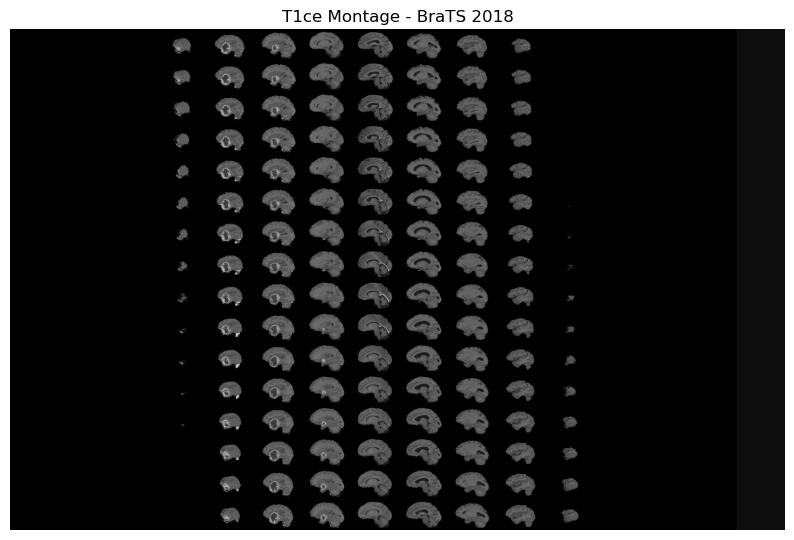

In [27]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import montage

# 1. Define the BraTS 2018 dataset folder path
dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It first looks for "HGG" and "LGG" subdirectories; if none are found,
    it considers folders directly under the dataset folder.
    """
    patient_folders = []
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    return patient_folders

# 2. Get patient folders and pick a sample patient
patient_folders = get_patient_folders(dataset_folder_2018)
if not patient_folders:
    raise ValueError("No patient folders found in the BraTS 2018 dataset.")

sample_patient = patient_folders[0]
print("Using sample patient folder:", sample_patient)

# 3. Locate the T1ce file
t1ce_files = [f for f in os.listdir(sample_patient)
              if "t1ce" in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
if not t1ce_files:
    raise FileNotFoundError(f"No T1ce file found in: {sample_patient}")

t1ce_path = os.path.join(sample_patient, t1ce_files[0])
print("Using T1ce file:", t1ce_path)

# 4. Load the T1ce volume
t1ce_nifti = nib.load(t1ce_path)
test_image_t1ce = t1ce_nifti.get_fdata(dtype=np.float32)  # shape: (D, H, W) or (H, W, D), etc.

# 5. Display a montage of all slices, rotated 90 degrees
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
# montage() concatenates slices of a 3D volume into a 2D grid
# rotate(..., 90) rotates the entire montage by 90 degrees for easier viewing
plt.imshow(rotate(montage(test_image_t1ce), 90, resize=True), cmap='gray')
plt.title("T1ce Montage - BraTS 2018")
plt.axis("off")
plt.show()


Using sample patient folder: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1
Using T1ce file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii


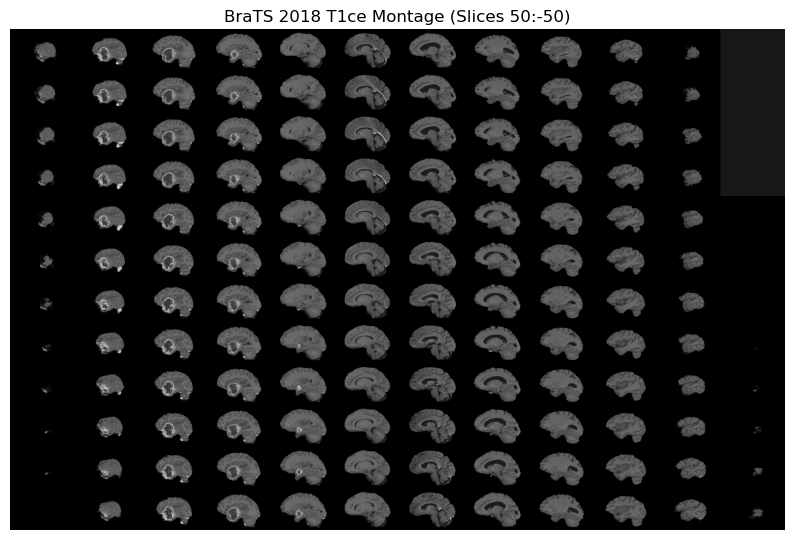

In [29]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import montage

# Define the BraTS 2018 dataset folder path
dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It looks for "HGG" and "LGG" subdirectories.
    """
    patient_folders = []
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    return patient_folders

# Get the list of patient folders and select the first patient
patient_folders = get_patient_folders(dataset_folder_2018)
if not patient_folders:
    raise Exception("No patient folders found in the BraTS 2018 dataset.")
sample_patient = patient_folders[0]
print("Using sample patient folder:", sample_patient)

# Locate the T1ce file in the sample patient folder
t1ce_files = [f for f in os.listdir(sample_patient) 
              if "t1ce" in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
if not t1ce_files:
    raise Exception("No T1ce file found in the patient folder:", sample_patient)
t1ce_path = os.path.join(sample_patient, t1ce_files[0])
print("Using T1ce file:", t1ce_path)

# Load the T1ce image using nibabel
t1ce_nifti = nib.load(t1ce_path)
test_image_t1ce = t1ce_nifti.get_fdata(dtype=np.float32)

# Skip the first and last 50 slices because they contain less informative data
sliced_volume = test_image_t1ce[50:-50, :, :]

# Create a montage from the remaining slices and rotate it by 90° for better visualization
montage_image = montage(sliced_volume)
rotated_montage = rotate(montage_image, 90, resize=True)

# Plot the montage
plt.figure(figsize=(10, 10))
plt.imshow(rotated_montage, cmap='gray')
plt.title("BraTS 2018 T1ce Montage (Slices 50:-50)")
plt.axis("off")
plt.show()


Using sample patient folder: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1
Using segmentation file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_seg.nii


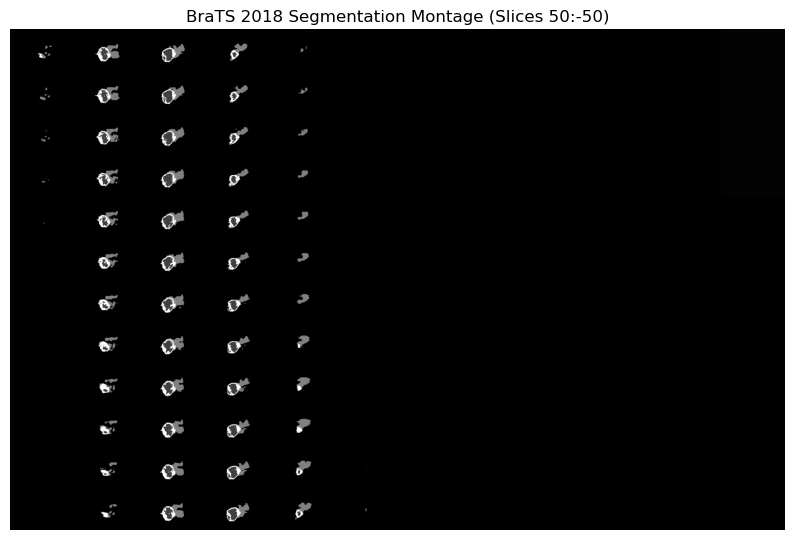

In [31]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import montage

# Define the BraTS 2018 dataset folder path
dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It looks for "HGG" and "LGG" subdirectories.
    """
    patient_folders = []
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    return patient_folders

# Get patient folders from the BraTS 2018 dataset
patient_folders = get_patient_folders(dataset_folder_2018)
if not patient_folders:
    raise Exception("No patient folders found in the BraTS 2018 dataset.")

# Select a sample patient folder
sample_patient = patient_folders[0]
print("Using sample patient folder:", sample_patient)

# Locate the segmentation file in the sample patient folder
seg_files = [f for f in os.listdir(sample_patient) 
             if "seg" in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
if not seg_files:
    raise Exception("No segmentation file found in the patient folder:", sample_patient)
seg_path = os.path.join(sample_patient, seg_files[0])
print("Using segmentation file:", seg_path)

# Load the segmentation volume using nibabel
seg_nifti = nib.load(seg_path)
test_image_seg = seg_nifti.get_fdata(dtype=np.float32)

# Skip the first and last 50 slices (since these slices have little information)
sliced_seg = test_image_seg[50:-50, :, :]

# Create a montage of the remaining slices and rotate it by 90° for better visualization
montage_seg = montage(sliced_seg)
rotated_montage_seg = rotate(montage_seg, 90, resize=True)

# Plot the montage
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotated_montage_seg, cmap='gray')
plt.title("BraTS 2018 Segmentation Montage (Slices 50:-50)")
plt.axis("off")
plt.show()


Using sample patient folder: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1
Using segmentation file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_seg.nii


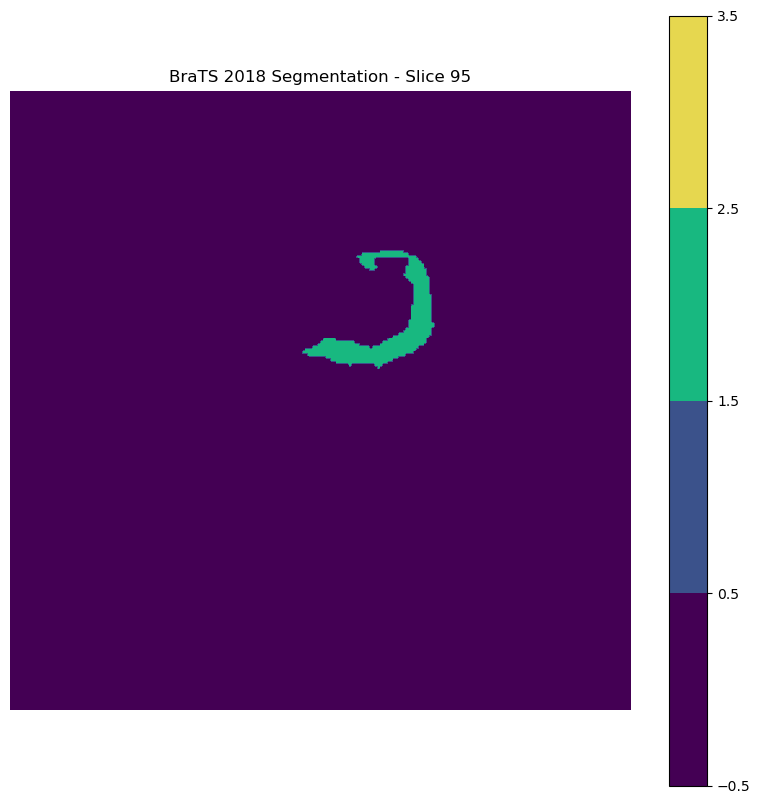

In [24]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

# Define the BraTS 2018 dataset folder path
dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"

def get_patient_folders(dataset_folder):
    """
    Returns a list of patient folder paths from the given dataset folder.
    It looks for "HGG" and "LGG" subdirectories.
    """
    patient_folders = []
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    return patient_folders

# Get all patient folders from BraTS 2018
patient_folders = get_patient_folders(dataset_folder_2018)
if not patient_folders:
    raise Exception("No patient folders found in the BraTS 2018 dataset.")

# Select a sample patient (first one)
sample_patient = patient_folders[0]
print("Using sample patient folder:", sample_patient)

# Locate the segmentation file (look for 'seg' in filename)
seg_files = [f for f in os.listdir(sample_patient)
             if "seg" in f.lower() and (f.endswith(".nii") or f.endswith(".nii.gz"))]
if not seg_files:
    raise Exception("No segmentation file found in the patient folder:", sample_patient)

seg_path = os.path.join(sample_patient, seg_files[0])
print("Using segmentation file:", seg_path)

# Load the segmentation volume using nibabel
seg_nifti = nib.load(seg_path)
test_image_seg = seg_nifti.get_fdata(dtype=np.float32)

# Plot the 95th slice using a custom colormap
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.figure(figsize=(10, 10))
plt.imshow(test_image_seg[:, :, 95], cmap=cmap, norm=norm)
plt.colorbar()
plt.title("BraTS 2018 Segmentation - Slice 95")
plt.axis("off")
plt.show()


Using sample patient folder: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1
Flair file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_flair.nii
T1ce file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_t1ce.nii
Segmentation file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_seg.nii
Flair shape: (240, 240, 155)
T1ce shape: (240, 240, 155)
Segmentation shape: (240, 240, 155)


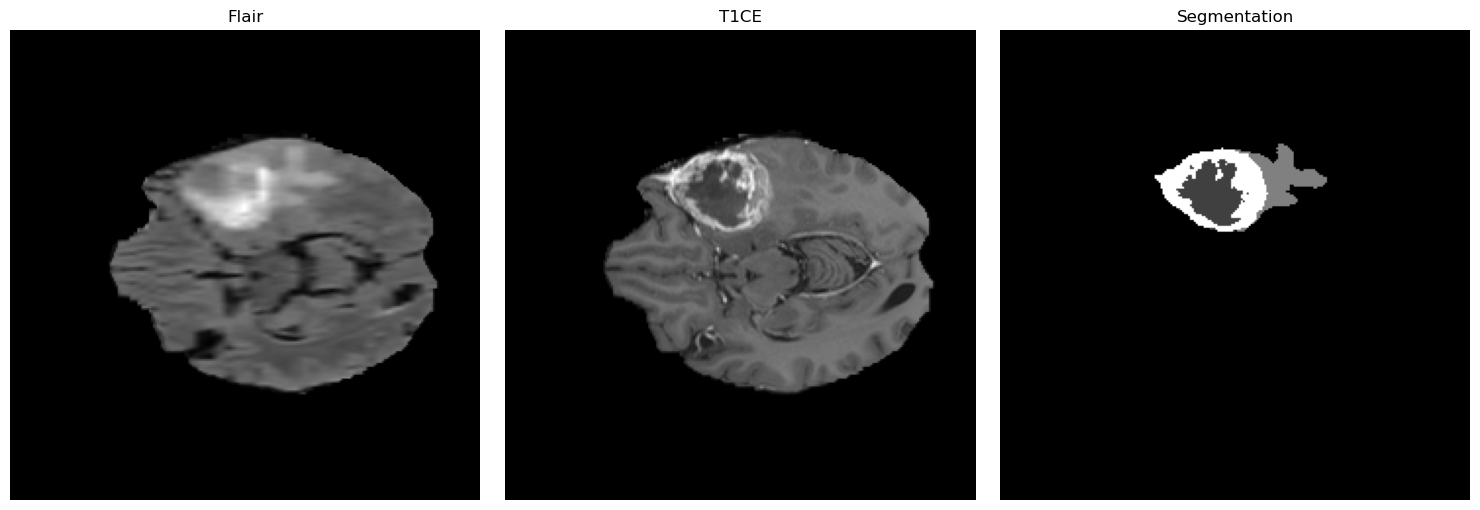

In [33]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')
    
    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')
    
    axes[2].imshow(segmentation, cmap='gray')
    axes[2].set_title('Segmentation')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

def get_patient_folders(dataset_folder):
    patient_folders = []
    for subfolder in ["HGG", "LGG"]:
        subfolder_path = os.path.join(dataset_folder, subfolder)
        if os.path.exists(subfolder_path):
            for patient in os.listdir(subfolder_path):
                patient_path = os.path.join(subfolder_path, patient)
                if os.path.isdir(patient_path):
                    patient_folders.append(patient_path)
    return patient_folders

# Set the BraTS 2018 dataset folder path
dataset_folder_2018 = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"

# Get patient folders
patient_folders = get_patient_folders(dataset_folder_2018)
if not patient_folders:
    raise Exception("No patient folders found in the BraTS 2018 dataset.")

# Choose a sample patient
sample_patient = patient_folders[0]
print("Using sample patient folder:", sample_patient)

# Locate the required files
flair_files = [f for f in os.listdir(sample_patient) if "flair" in f.lower() and f.endswith((".nii", ".nii.gz"))]
t1ce_files  = [f for f in os.listdir(sample_patient) if "t1ce"  in f.lower() and f.endswith((".nii", ".nii.gz"))]
seg_files   = [f for f in os.listdir(sample_patient) if "seg"   in f.lower() and f.endswith((".nii", ".nii.gz"))]

if not flair_files or not t1ce_files or not seg_files:
    raise Exception("One or more required files (Flair, T1ce, or Segmentation) not found.")

flair_path = os.path.join(sample_patient, flair_files[0])
t1ce_path  = os.path.join(sample_patient, t1ce_files[0])
seg_path   = os.path.join(sample_patient, seg_files[0])
print("Flair file:", flair_path)
print("T1ce file:", t1ce_path)
print("Segmentation file:", seg_path)

# Load the volumes using nibabel
flair_img = nib.load(flair_path).get_fdata(dtype=np.float32)
t1ce_img  = nib.load(t1ce_path).get_fdata(dtype=np.float32)
seg_img   = nib.load(seg_path).get_fdata(dtype=np.float32)

print("Flair shape:", flair_img.shape)
print("T1ce shape:", t1ce_img.shape)
print("Segmentation shape:", seg_img.shape)

# Choose a slice index (e.g. 60) from the 3rd axis
slice_index = 60
flair_slice = flair_img[:, :, slice_index]
t1ce_slice  = t1ce_img[:, :, slice_index]
seg_slice   = seg_img[:, :, slice_index]

# Display the slice and its segmentation
display_slice_and_segmentation(flair_slice, t1ce_slice, seg_slice)


Found 285 segmentation files.
Processing segmentation file: C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_10_1\Brats18_2013_10_1_seg.nii


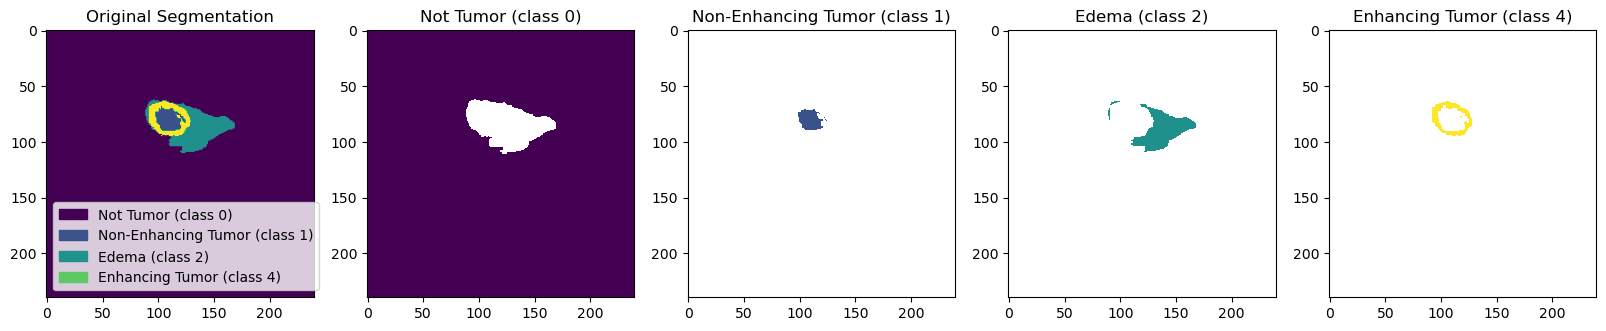

In [35]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Function to find segmentation files
def find_segmentation_files(dataset_folder):
    """
    Recursively searches for segmentation files (*.nii or *.nii.gz) containing 'seg' in the filename.
    Returns a list of all found segmentation file paths.
    """
    segmentation_files = []
    for root, _, files in os.walk(dataset_folder):
        for file in files:
            if "seg" in file and file.endswith((".nii", ".nii.gz")):
                segmentation_files.append(os.path.join(root, file))
    return segmentation_files

# Define dataset path
dataset_folder = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"

# Find segmentation files
segmentation_file_paths = find_segmentation_files(dataset_folder)

# Check if segmentation files are found
if not segmentation_file_paths:
    print("No segmentation files found.")
    exit()

print(f"Found {len(segmentation_file_paths)} segmentation files.")

# Load the first segmentation file for visualization
segmentation_path = segmentation_file_paths[0]  # Choose the first found file
print(f"Processing segmentation file: {segmentation_path}")

# Load the NIfTI file
segmentation_nifti = nib.load(segmentation_path)
segmentation_data = segmentation_nifti.get_fdata()

# Select a middle slice for visualization
slice_idx = segmentation_data.shape[2] // 2
test_image_seg = segmentation_data[:, :, slice_idx]

# Isolation of tumor classes
seg_0 = np.where(test_image_seg == 0, test_image_seg, np.nan)
seg_1 = np.where(test_image_seg == 1, test_image_seg, np.nan)
seg_2 = np.where(test_image_seg == 2, test_image_seg, np.nan)
seg_4 = np.where(test_image_seg == 4, test_image_seg, np.nan)

# Define colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=4)

# Define legend
class_names = ['Not Tumor (class 0)', 'Non-Enhancing Tumor (class 1)', 'Edema (class 2)', 'Enhancing Tumor (class 4)']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i/4), label=class_names[i]) for i in range(len(class_names))]

# Plot the segmentation classes
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg, cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0, cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1, cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2, cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4, cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()


In [37]:
import os
from sklearn.model_selection import train_test_split

# Define dataset paths
HGG_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG"
LGG_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\LGG"

# Get list of patient directories from HGG and LGG
hgg_patients = [os.path.join(HGG_PATH, f) for f in os.listdir(HGG_PATH) if os.path.isdir(os.path.join(HGG_PATH, f))]
lgg_patients = [os.path.join(LGG_PATH, f) for f in os.listdir(LGG_PATH) if os.path.isdir(os.path.join(LGG_PATH, f))]

# Combine both HGG and LGG patient folders
all_patient_dirs = hgg_patients + lgg_patients

# Extract patient IDs
def pathListIntoIds(dirList):
    return [os.path.basename(path) for path in dirList]

all_patient_ids = pathListIntoIds(all_patient_dirs)

# Check if there are enough samples for splitting
if len(all_patient_ids) > 1:
    train_test_ids, val_ids = train_test_split(all_patient_ids, test_size=0.2, random_state=42)

    if len(train_test_ids) > 1:
        train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)
    else:
        train_ids, test_ids = train_test_ids, []
else:
    train_ids = all_patient_ids
    val_ids = []
    test_ids = []

# Print dataset splits
print(f"Total Patients: {len(all_patient_ids)}")
print(f"Training Set: {len(train_ids)}")
print(f"Validation Set: {len(val_ids)}")
print(f"Test Set: {len(test_ids)}")


Total Patients: 285
Training Set: 193
Validation Set: 57
Test Set: 35


In [39]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 193
Validation length: 57
Test length: 35


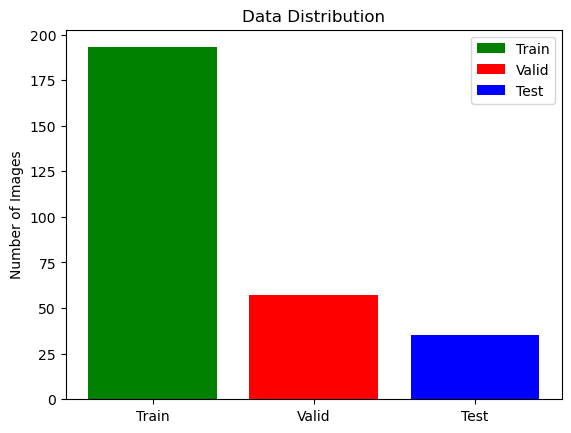

In [41]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()

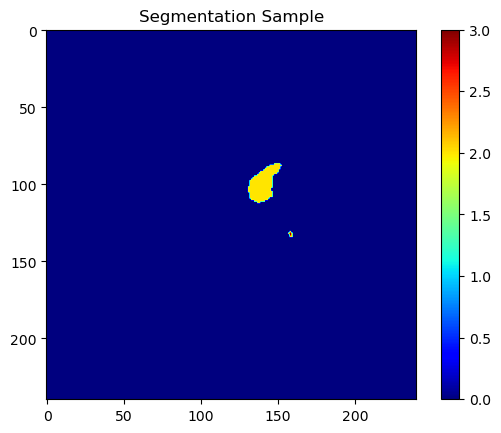

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Define segmentation class mappings
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',  # Non-Enhancing Tumor Core
    2: 'EDEMA',
    4: 'ENHANCING'  # Class 4 is used in BraTS, no need to change to 3
}

# Dataset Configuration
VOLUME_SLICES = 100  # Number of slices to extract
VOLUME_START_AT = 22  # Starting slice to consider
IMG_SIZE = 128  # Resize image to this size

# Function to load and preprocess segmentation file
def load_segmentation(patient_folder):
    seg_file = [f for f in os.listdir(patient_folder) if "seg.nii" in f]
    
    if not seg_file:
        print(f"Segmentation file missing in {patient_folder}")
        return None
    
    seg_path = os.path.join(patient_folder, seg_file[0])
    seg_data = nib.load(seg_path).get_fdata()
    
    # Normalize segmentation labels
    seg_data[seg_data == 4] = 3  # Convert class 4 to 3 (optional)
    
    return seg_data

# Example Usage
sample_patient = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_2_1"
segmentation_data = load_segmentation(sample_patient)

if segmentation_data is not None:
    # Select a middle slice for visualization
    slice_idx = segmentation_data.shape[2] // 2  
    plt.imshow(segmentation_data[:, :, slice_idx], cmap="jet")
    plt.title("Segmentation Sample")
    plt.colorbar()
    plt.show()


In [11]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow import keras

# Define dataset paths
BASE_DATASET_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"
HGG_PATH = os.path.join(BASE_DATASET_PATH, "HGG")
LGG_PATH = os.path.join(BASE_DATASET_PATH, "LGG")

# Define segmentation classes
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    4: 'ENHANCING'
}

# Define constants
VOLUME_SLICES = 100  # Number of slices per volume
VOLUME_START_AT = 22  # First slice to include
IMG_SIZE = 128  # Resize image to this size

# Get list of patient folders
patient_folders = [os.path.join(HGG_PATH, f) for f in os.listdir(HGG_PATH) if os.path.isdir(os.path.join(HGG_PATH, f))]
patient_folders += [os.path.join(LGG_PATH, f) for f in os.listdir(LGG_PATH) if os.path.isdir(os.path.join(LGG_PATH, f))]

# Extract patient IDs
patient_ids = [os.path.basename(p) for p in patient_folders]

# Split dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split
train_test_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)


# Data Generator Class
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs  # List of patient IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        
        for c, patient_id in enumerate(Batch_ids):
            # Find patient folder in HGG or LGG
            patient_folder = None
            for path in [HGG_PATH, LGG_PATH]:
                temp_path = os.path.join(path, patient_id)
                if os.path.exists(temp_path):
                    patient_folder = temp_path
                    break

            if not patient_folder:
                print(f"Patient {patient_id} not found!")
                continue

            # Load modalities
            flair_path = os.path.join(patient_folder, f'{patient_id}_flair.nii')
            t1ce_path = os.path.join(patient_folder, f'{patient_id}_t1ce.nii')
            seg_path = os.path.join(patient_folder, f'{patient_id}_seg.nii')

            # Load images
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            # Process slices
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Convert labels: 4 → 3 for consistency
        y[y == 4] = 3  

        # One-hot encode masks
        mask = tf.one_hot(y, 4)  
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        return X / np.max(X), Y


# Create Data Generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


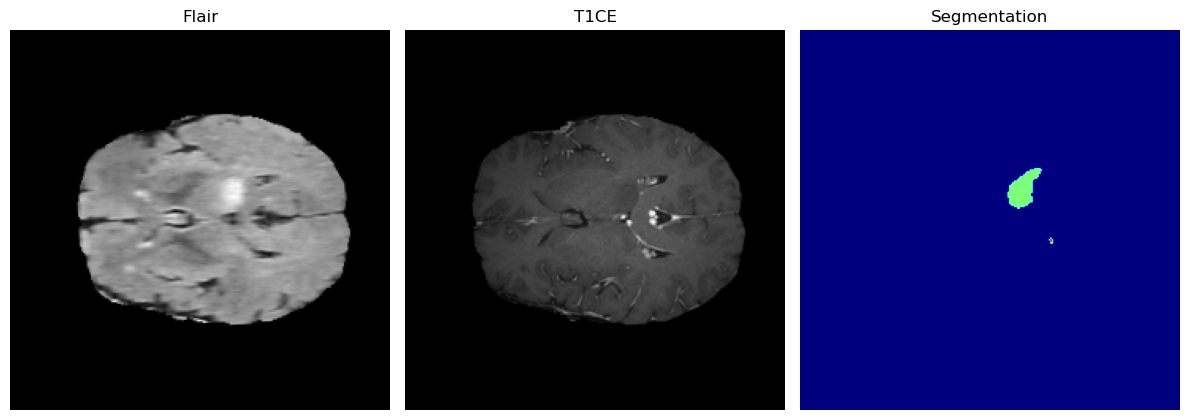

In [13]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Function to display MRI slices
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation, cmap='jet')  # Colormap for better contrast
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Define dataset path
dataset_path = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_2_1"

# Load MRI scans
flair_path = os.path.join(dataset_path, "Brats18_2013_2_1_flair.nii")
t1ce_path = os.path.join(dataset_path, "Brats18_2013_2_1_t1ce.nii")
segmentation_path = os.path.join(dataset_path, "Brats18_2013_2_1_seg.nii")

# Load images using nibabel
flair_img = nib.load(flair_path).get_fdata()
t1ce_img = nib.load(t1ce_path).get_fdata()
segmentation_img = nib.load(segmentation_path).get_fdata()

# Get the total number of slices and find the middle slice
num_slices = flair_img.shape[2]
middle_slice = num_slices // 2  # Middle slice index

# Extract the middle slice
flair_slice = flair_img[:, :, middle_slice]
t1ce_slice = t1ce_img[:, :, middle_slice]
segmentation_slice = segmentation_img[:, :, middle_slice]

# Display the middle slice
display_slice_and_segmentation(flair_slice, t1ce_slice, segmentation_slice)


In [15]:
import tensorflow.keras.backend as K
import tensorflow as tf

# Accuracy Metric
def accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)), axis=-1)

# Precision Metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=(1, 2, 3))
    possible_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=(1, 2, 3))
    return true_positives / (possible_positives + K.epsilon())

# Specificity Metric
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)), axis=(1, 2, 3))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)), axis=(1, 2, 3))
    return K.mean(true_negatives / (true_negatives + false_positives + K.epsilon()), axis=0)

# F1 Score Metric
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * (precision_val * recall_val) / (precision_val + recall_val + K.epsilon())

# Recall Metric (for F1 score)
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=(1, 2, 3))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=(1, 2, 3))
    return true_positives / (possible_positives + K.epsilon())

# Dice Similarity Coefficient (DSC)
def dice_coef(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2, 3))
    return (2. * intersection) / (K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) + K.epsilon())

# Confusion Matrix Metric
def confusion_matrix_metrics(y_true, y_pred):
    y_true_flat = K.flatten(K.argmax(y_true, axis=-1))
    y_pred_flat = K.flatten(K.argmax(y_pred, axis=-1))
    
    # Calculate confusion matrix
    cm = tf.math.confusion_matrix(y_true_flat, y_pred_flat, num_classes=4)
    
    return cm


In [17]:
    #Feature Extraction
    import tensorflow as tf
    from tensorflow.keras.layers import (Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, 
                                         Add, Concatenate, LayerNormalization)
    from tensorflow.keras.models import Model
    
    def instance_norm(x):
        """Instance Normalization layer"""
        return LayerNormalization(axis=[1, 2])(x)
    
    def dilated_conv_block(x, filters, dilation_rate):
        """Dilated Convolution Block"""
        x = Conv2D(filters, kernel_size=3, padding="same", dilation_rate=dilation_rate, kernel_initializer="he_normal")(x)
        x = instance_norm(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x
    
    def M2GC_block(x, filters):
        """M2GCNet Module (SGCM + CGCM)"""
        x1 = dilated_conv_block(x, filters, dilation_rate=2)
        x1 = Dropout(0.3)(x1)
        x2 = dilated_conv_block(x1, filters, dilation_rate=4)
        return Add()([x, x2])  # Element-wise summation
    
    def encoder_block(x, filters):
        """Encoder block with strided convolution"""
        x = Conv2D(filters, kernel_size=3, strides=2, padding="same", kernel_initializer="he_normal")(x)
        x = instance_norm(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x
    
    def decoder_block(x, skip, filters):
        """Decoder block with upsampling"""
        x = UpSampling2D(size=(2, 2))(x)
        x = Conv2D(filters, kernel_size=1, padding="same", kernel_initializer="he_normal")(x)  # Conv 1x1
        x = Add()([x, skip])  # Element-wise summation
        return x
    
    def build_m2gc_unet(input_shape):
        inputs = Input(input_shape)
    
        # Encoder
        e1 = dilated_conv_block(inputs, 32, dilation_rate=1)
        e2 = encoder_block(e1, 64)
        e3 = encoder_block(e2, 128)
        e4 = encoder_block(e3, 256)
        e5 = encoder_block(e4, 512)
    
        # M2GC Block (SGCM + CGCM)
        bridge = M2GC_block(e5, 512)
    
        # Decoder
        d4 = decoder_block(bridge, e4, 256)
        d3 = decoder_block(d4, e3, 128)
        d2 = decoder_block(d3, e2, 64)
        d1 = decoder_block(d2, e1, 32)
    
        outputs = Conv2D(4, kernel_size=1, activation="softmax")(d1)  # Output layer with 4 classes
    
        return Model(inputs, outputs)
    
    # Define model
    IMG_SIZE = 128
    input_shape = (IMG_SIZE, IMG_SIZE, 2)  # Assuming 2 input channels (e.g., MRI modalities)
    model = build_m2gc_unet(input_shape)
    
    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])
    
    # Summary
    model.summary()


C:\Users\kesav\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        608 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 128, 128,  │     32,768 │ conv2d[0][0]      │
│ (LayerNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 128, 128,  │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64,    │      8,192 │ conv2d_1[0][0]    │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 64, 64,    │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ leaky_re_lu_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_2[0][0]    │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32, 32,    │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    295,168 │ leaky_re_lu_2[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (LayerNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 16, 16,    │          0 │ layer_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 8, 512) │        128 │ conv2d_4[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 8, 8, 512) │          0 │ layer_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 512) │  2,359,808 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,506,500 (24.82 MB)

 Trainable params: 6,506,500 (24.82 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

# Define the input layer (as you did)
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Ensure the correct function is used
model = build_m2gc_unet((IMG_SIZE, IMG_SIZE, 2))

# Compile the model with custom metrics
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=[
                  accuracy,              # Custom accuracy metric
                  tf.keras.metrics.MeanIoU(num_classes=4),  # Mean IoU
                  dice_coef,             # Custom Dice coefficient
                  precision,             # Custom precision
                  specificity,           # Custom specificity
                  f1_score               # Custom F1 score
              ])


In [21]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf

# Plot the model
plot_model(model,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=70)

# Display the plot
plt.show()


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                      patience=2, min_lr=0.000001, verbose=1),
    
    ModelCheckpoint(filepath='model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                    verbose=1, save_best_only=True, save_weights_only=True),
    
    CSVLogger('training.log', separator=',', append=False)
]


In [25]:
import os
import numpy as np
import nibabel as nib
import cv2
import tensorflow as tf
from tensorflow import keras

# ✅ Define dataset paths
BASE_DATASET_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training"
HGG_PATH = os.path.join(BASE_DATASET_PATH, "HGG")
LGG_PATH = os.path.join(BASE_DATASET_PATH, "LGG")

# ✅ Define segmentation classes
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA',
    4: 'ENHANCING'
}

# ✅ Constants
VOLUME_SLICES = 100  # Number of slices per volume
VOLUME_START_AT = 22  # First slice to include
IMG_SIZE = 128  # Resize image to this size

# ✅ Get patient folders
patient_folders = [os.path.join(HGG_PATH, f) for f in os.listdir(HGG_PATH) if os.path.isdir(os.path.join(HGG_PATH, f))]
patient_folders += [os.path.join(LGG_PATH, f) for f in os.listdir(LGG_PATH) if os.path.isdir(os.path.join(LGG_PATH, f))]

# ✅ Extract patient IDs
patient_ids = [os.path.basename(p) for p in patient_folders]

# ✅ Split dataset
from sklearn.model_selection import train_test_split
train_test_ids, val_ids = train_test_split(patient_ids, test_size=0.2, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# ✅ Data Generator Class
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs  
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(Batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels), dtype=np.float32)
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240), dtype=np.uint8)
        
        for c, patient_id in enumerate(Batch_ids):
            patient_folder = None
            for path in [HGG_PATH, LGG_PATH]:
                temp_path = os.path.join(path, patient_id)
                if os.path.exists(temp_path):
                    patient_folder = temp_path
                    break

            if not patient_folder:
                print(f"⚠️ Patient {patient_id} not found, skipping...")
                continue

            # ✅ Detect file extensions
            flair_path = os.path.join(patient_folder, f'{patient_id}_flair.nii.gz')
            t1ce_path = os.path.join(patient_folder, f'{patient_id}_t1ce.nii.gz')
            seg_path = os.path.join(patient_folder, f'{patient_id}_seg.nii.gz')

            if not os.path.exists(flair_path):
                flair_path = flair_path.replace(".nii.gz", ".nii")
            if not os.path.exists(t1ce_path):
                t1ce_path = t1ce_path.replace(".nii.gz", ".nii")
            if not os.path.exists(seg_path):
                seg_path = seg_path.replace(".nii.gz", ".nii")

            # ✅ Check if all files exist
            if not all(map(os.path.exists, [flair_path, t1ce_path, seg_path])):
                print(f"⚠️ Missing files for patient {patient_id}, skipping...")
                continue

            # ✅ Load MRI images
            flair = nib.load(flair_path).get_fdata()
            t1ce = nib.load(t1ce_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            # ✅ Process slices
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # ✅ Convert labels: 4 → 3 (for consistency)
        y[y == 4] = 3  

        # ✅ One-hot encode masks
        mask = tf.one_hot(y, 4)  
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # ✅ Fix division error
        max_val = np.max(X)
        if max_val > 0:
            X /= max_val  
        else:
            X = np.zeros_like(X)  # Avoid NaN values

        return X, Y


# ✅ Create Data Generators
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

# ✅ Verify output
batch_x, batch_y = next(iter(training_generator))
print(f"✅ Generator Output Shapes - Images: {batch_x.shape}, Masks: {batch_y.shape}")


✅ Generator Output Shapes - Images: (100, 128, 128, 2), Masks: (100, 128, 128, 4)


In [27]:
# Model Training
history = model.fit(
    training_generator,
    epochs=10,
    steps_per_epoch=len(train_ids) // training_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=callbacks,  # Ensure you define any callbacks such as EarlyStopping
    verbose=1
)


C:\Users\kesav\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9528 - dice_coef: 0.9513 - f1_score: 0.9526 - loss: 0.6906 - mean_io_u_1: 0.7690 - precision: 0.9530 - specificity: 0.9846
Epoch 1: val_loss improved from inf to 0.05182, saving model to model_.01-0.051819.weights.h5
193/193 ━━━━━━━━━━━━━━━━━━━━ 1333s 7s/step - accuracy: 0.9529 - dice_coef: 0.9514 - f1_score: 0.9527 - loss: 0.6884 - mean_io_u_1: 0.7682 - precision: 0.9532 - specificity: 0.9846 - val_accuracy: 0.9858 - val_dice_coef: 0.9823 - val_f1_score: 0.9856 - val_loss: 0.0518 - val_mean_io_u_1: 0.4530 - val_precision: 0.9867 - val_specificity: 0.9958 - learning_rate: 0.0010
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9851 - dice_coef: 0.9811 - f1_score: 0.9851 - loss: 0.0559 - mean_io_u_1: 0.4380 - precision: 0.9862 - specificity: 0.9956
Epoch 2: val_loss did not improve from 0.05182
193/193 ━━━━━━━━━━━━━━━━━━━━ 1383s 7s/step - accuracy: 0.9851 - dice_coef: 0.9811 - f1_score: 0.9851 - loss: 0.055

In [29]:
model.save("my_model.keras")

In [31]:
model.save(r'C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\my_model.keras')  # Saves in the specified directory


In [39]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
def accuracy(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)), axis=-1)

@register_keras_serializable()
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=(1, 2, 3))
    possible_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=(1, 2, 3))
    return true_positives / (possible_positives + K.epsilon())

@register_keras_serializable()
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=(1, 2, 3))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=(1, 2, 3))
    return true_positives / (possible_positives + K.epsilon())

@register_keras_serializable()
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * (precision_val * recall_val) / (precision_val + recall_val + K.epsilon())

@register_keras_serializable()
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)), axis=(1, 2, 3))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)), axis=(1, 2, 3))
    return K.mean(true_negatives / (true_negatives + false_positives + K.epsilon()), axis=0)

@register_keras_serializable()
def dice_coef(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=(1, 2, 3))
    return (2. * intersection) / (K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) + K.epsilon())


In [41]:
model.compile(optimizer='rmsprop', loss='your_loss', metrics=['your_metrics'])


In [43]:
import nibabel as nib
import numpy as np
import cv2

def imageLoader(path, ce, seg, IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT, batch_size, n_channels, dim):
    # Load the FLAIR image
    flair_path = os.path.join(path, f'BraTS19_2013_3_1_{ce}_flair.nii')
    flair = nib.load(flair_path).get_fdata()

    # Initialize the data arrays
    X = np.zeros((batch_size * VOLUME_SLICES, *dim, n_channels))  # Initialize X for images
    y = np.zeros((batch_size * VOLUME_SLICES, *dim))  # Initialize y for segmentations
    
    for c in range(batch_size):
        for j in range(VOLUME_SLICES):
            # Resize and load the FLAIR and T1CE images into X
            X[j + VOLUME_SLICES*c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            X[j + VOLUME_SLICES*c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
            # Resize and load the segmentation mask into y
            y[j + VOLUME_SLICES*c] = seg[:, :, j + VOLUME_START_AT]

    return np.array(X), np.array(y)



In [45]:
import glob
import cv2
import numpy as np

def loadDataFromDir(path, list_of_files, mriType, n_images, IMG_SIZE, imageLoader):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        # Get full path to MRI scan and corresponding segmentation mask
        fullPath = glob.glob(os.path.join(i, f'*{mriType}*.nii*'))[0]
        currentScanVolume, _ = imageLoader(fullPath)  # Load scan images

        # Find the corresponding segmentation mask
        seg_path = glob.glob(os.path.join(i, '*_seg.nii*'))[0]
        currentMaskVolume, _ = imageLoader(seg_path)  # Load corresponding masks

        # Iterate through slices in the 3D scan volume and resize
        for j in range(currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:, :, j], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])

    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')


In [47]:
import os
import nibabel as nib
import cv2
import numpy as np

def predictByPath(case_path, case, model, IMG_SIZE, VOLUME_SLICES, VOLUME_START_AT):
    # Initialize the empty array for input data
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Load FLAIR and T1CE images
    flair_path = os.path.join(case_path, f'BraTS19_2013_3_1_{case}_flair.nii')
    t1ce_path = os.path.join(case_path, f'BraTS19_2013_3_1_{case}_t1ce.nii')

    try:
        flair = nib.load(flair_path).get_fdata()
        t1ce = nib.load(t1ce_path).get_fdata()
    except FileNotFoundError:
        print(f"Error: Files not found for case {case}.")
        return None

    # Resize each slice to IMG_SIZE and store in X
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize the input data before prediction
    X = X / np.max(X)

    # Predict using the model
    prediction = model.predict(X, verbose=1)
    return prediction


In [49]:
def predictByPath(path, case):
    # This function should load the model and predict the segmentation for the case.
    # Example placeholder (you should replace it with your actual model prediction logic):
    model = load_model('your_model_path')  # Load the trained model
    # Assuming the model takes an image and outputs predictions for edema, core, and enhancing
    image_data = load_image_data(path, case)  # Replace with your data loading function
    predictions = model.predict(image_data)
    return predictions


In [51]:
import os
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

def showPredictsById(case, start_slice=60, IMG_SIZE=128, VOLUME_START_AT=0, SEGMENT_CLASSES=["", "Edema", "Core", "Enhancing"]):
    # Define the base dataset path
    base_path = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG"
    
    # List available folders to check correct folder name
    available_folders = os.listdir(base_path)
    print("Available folders in HGG:", available_folders)
    
    # Construct the correct case path
    case_folder = None
    for folder in available_folders:
        if case in folder:
            case_folder = folder
            break
    
    if not case_folder:
        print(f"Error: No folder found for case '{case}' in HGG directory.")
        return
    
    path = os.path.join(base_path, case_folder)
    print("Accessing path:", path)
    
    # Verify the path exists
    if not os.path.exists(path):
        print("Error: Directory does not exist:", path)
        return
    
    # List files for debugging
    files = os.listdir(path)
    print("Files in directory:", files)

    try:
        # Check if necessary files exist
        flair_path = os.path.join(path, f'{case_folder}_flair.nii.gz')
        seg_path = os.path.join(path, f'{case_folder}_seg.nii.gz')
        
        if not os.path.exists(flair_path):
            print("FLAIR image not found:", flair_path)
            return
        if not os.path.exists(seg_path):
            print("Segmentation image not found:", seg_path)
            return
        
        # Load the ground truth and FLAIR images
        gt = nib.load(seg_path).get_fdata()
        origImage = nib.load(flair_path).get_fdata()

        # Assuming `predictByPath` is a valid function that predicts segmentation (needs to be defined)
        p = predictByPath(path, case_folder)  # Ensure predictByPath is implemented correctly

        # Extract predicted segmentations (Edema, Core, Enhancing)
        core = p[:, :, :, 1]
        edema = p[:, :, :, 2]
        enhancing = p[:, :, :, 3]

        # Create subplots to display the results
        plt.figure(figsize=(18, 50))
        f, axarr = plt.subplots(1, 6, figsize=(18, 50))

        # Display original FLAIR image
        axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
        axarr[0].title.set_text('Original image (FLAIR)')

        # Display ground truth
        curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
        axarr[1].title.set_text('Ground truth')

        # Display all predicted classes
        axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
        axarr[2].title.set_text('All classes predicted')

        # Display edema, core, and enhancing separately
        axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
        axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

        axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
        axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

        axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
        axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

        # Show plot
        plt.show()

    except Exception as e:
        print("Error occurred:", e)

# Example usage
showPredictsById(case="2013_2_1", start_slice=60)


Available folders in HGG: ['BraTS19_2013_10_1', 'BraTS19_2013_11_1', 'BraTS19_2013_12_1', 'BraTS19_2013_13_1', 'BraTS19_2013_14_1', 'BraTS19_2013_17_1', 'BraTS19_2013_18_1', 'BraTS19_2013_19_1', 'BraTS19_2013_20_1', 'BraTS19_2013_21_1', 'BraTS19_2013_22_1', 'BraTS19_2013_23_1', 'BraTS19_2013_25_1', 'BraTS19_2013_26_1', 'BraTS19_2013_27_1', 'BraTS19_2013_2_1', 'BraTS19_2013_3_1', 'BraTS19_2013_4_1', 'BraTS19_2013_5_1', 'BraTS19_2013_7_1', 'BraTS19_CBICA_AAB_1', 'BraTS19_CBICA_AAG_1', 'BraTS19_CBICA_AAL_1', 'BraTS19_CBICA_AAP_1', 'BraTS19_CBICA_ABB_1', 'BraTS19_CBICA_ABE_1', 'BraTS19_CBICA_ABM_1', 'BraTS19_CBICA_ABN_1', 'BraTS19_CBICA_ABO_1', 'BraTS19_CBICA_ABY_1', 'BraTS19_CBICA_ALN_1', 'BraTS19_CBICA_ALU_1', 'BraTS19_CBICA_ALX_1', 'BraTS19_CBICA_AME_1', 'BraTS19_CBICA_AMH_1', 'BraTS19_CBICA_ANG_1', 'BraTS19_CBICA_ANI_1', 'BraTS19_CBICA_ANP_1', 'BraTS19_CBICA_ANV_1', 'BraTS19_CBICA_ANZ_1', 'BraTS19_CBICA_AOC_1', 'BraTS19_CBICA_AOD_1', 'BraTS19_CBICA_AOH_1', 'BraTS19_CBICA_AOO_1', 'BraTS

In [53]:
print(os.listdir(r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2019\MICCAI_BraTS_2019_Data_Training\MICCAI_BraTS_2019_Data_Training\HGG\BraTS19_2013_2_1"))


['BraTS19_2013_2_1_flair.nii', 'BraTS19_2013_2_1_seg.nii', 'BraTS19_2013_2_1_t1.nii', 'BraTS19_2013_2_1_t1ce.nii', 'BraTS19_2013_2_1_t2.nii']


In [410]:
import os
import random
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Constants
TRAIN_DATASET_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG"
VOLUME_START_AT = 0  
IMG_SIZE = 128  

# Debugging: Verify dataset path
if not os.path.exists(TRAIN_DATASET_PATH):
    print(f"Error: Base dataset path '{TRAIN_DATASET_PATH}' does not exist.")
else:
    print("Available Directories:", os.listdir(TRAIN_DATASET_PATH))

# Dummy function for predicted segmentation
def predict_segmentation(case_path):
    return np.random.random((75, IMG_SIZE, IMG_SIZE, 4))  # Assuming 4-class prediction

# Function to show segmentation
def show_predicted_segmentations(samples_list, slice_to_plot, cmap="gray", norm=None):
    random_sample = random.choice(samples_list).strip()  # Remove any spaces
    sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample)

    # Debugging: Check if folder exists
    if not os.path.exists(sample_path):
        print(f"Error: Patient directory '{sample_path}' not found. Available directories: {os.listdir(TRAIN_DATASET_PATH)}")
        return

    # Verify if segmentation file exists
    seg_file = f"{random_sample}_seg.nii.gz"
    seg_path = os.path.join(sample_path, seg_file)

    if not os.path.exists(seg_path):
        print(f"Error: Segmentation file '{seg_file}' not found in {sample_path}.")
        return

    # Load ground truth segmentation
    seg = nib.load(seg_path).get_fdata()
    seg = cv2.resize(seg[:, :, slice_to_plot + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Get model predictions
    predicted_seg = predict_segmentation(sample_path)
    
    # Extract predicted segmentation layers
    all_classes = predicted_seg[slice_to_plot, :, :, 1:4]  # Exclude background class
    background = predicted_seg[slice_to_plot, :, :, 0]
    core = predicted_seg[slice_to_plot, :, :, 1]
    edema = predicted_seg[slice_to_plot, :, :, 2]
    enhancing = predicted_seg[slice_to_plot, :, :, 3]

    # Plot results
    fig, ax = plt.subplots(1, 6, figsize=(25, 20))
    
    ax[0].imshow(seg, cmap, norm)
    ax[0].set_title('Ground Truth')

    ax[1].imshow(all_classes, cmap, norm)
    ax[1].set_title('Predicted - All Classes')

    ax[2].imshow(background)
    ax[2].set_title('Predicted - Background')

    ax[3].imshow(core)
    ax[3].set_title('Predicted - Core')

    ax[4].imshow(edema)
    ax[4].set_title('Predicted - Edema')

    ax[5].imshow(enhancing)
    ax[5].set_title('Predicted - Enhancing')

    plt.subplots_adjust(wspace=0.8)
    plt.show()

# Example usage
samples_list = os.listdir(TRAIN_DATASET_PATH)  # List all sample directories
show_predicted_segmentations(samples_list, slice_to_plot=20)


Available Directories: ['Brats18_2013_10_1', 'Brats18_2013_11_1', 'Brats18_2013_12_1', 'Brats18_2013_13_1', 'Brats18_2013_14_1', 'Brats18_2013_17_1', 'Brats18_2013_18_1', 'Brats18_2013_19_1', 'Brats18_2013_20_1', 'Brats18_2013_21_1', 'Brats18_2013_22_1', 'Brats18_2013_23_1', 'Brats18_2013_25_1', 'Brats18_2013_26_1', 'Brats18_2013_27_1', 'Brats18_2013_2_1', 'Brats18_2013_3_1', 'Brats18_2013_4_1', 'Brats18_2013_5_1', 'Brats18_2013_7_1', 'Brats18_CBICA_AAB_1', 'Brats18_CBICA_AAG_1', 'Brats18_CBICA_AAL_1', 'Brats18_CBICA_AAP_1', 'Brats18_CBICA_ABB_1', 'Brats18_CBICA_ABE_1', 'Brats18_CBICA_ABM_1', 'Brats18_CBICA_ABN_1', 'Brats18_CBICA_ABO_1', 'Brats18_CBICA_ABY_1', 'Brats18_CBICA_ALN_1', 'Brats18_CBICA_ALU_1', 'Brats18_CBICA_ALX_1', 'Brats18_CBICA_AME_1', 'Brats18_CBICA_AMH_1', 'Brats18_CBICA_ANG_1', 'Brats18_CBICA_ANI_1', 'Brats18_CBICA_ANP_1', 'Brats18_CBICA_ANZ_1', 'Brats18_CBICA_AOD_1', 'Brats18_CBICA_AOH_1', 'Brats18_CBICA_AOO_1', 'Brats18_CBICA_AOP_1', 'Brats18_CBICA_AOZ_1', 'Brats18_

In [57]:
# Load the saved model with custom objects
custom_objects = {
    "dice_coef": dice_coef,
    "precision": precision,
    "sensitivity": sensitivity,
    "specificity": specificity
}

model = tf.keras.models.load_model("model.keras", custom_objects=custom_objects)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


C:\Users\kesav\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [59]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [61]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [63]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [65]:
#Segmentation


import os
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 128
VOLUME_START_AT = 0  # Adjust based on your dataset
DATASET_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG"

# Class labels
SEGMENT_CLASSES = {
    1: "Edema",
    2: "Core",
    3: "Enhancing"
}

# Dummy function for prediction (Replace with actual model inference)
def predictByPath(path, case):
    return np.random.random((75, IMG_SIZE, IMG_SIZE, 4))  # Dummy prediction (4 classes)

def showPredictsById(case, start_slice=60):
    case_path = os.path.join(DATASET_PATH, case)

    if not os.path.exists(case_path):
        print(f"❌ Error: Data for {case} not found in {DATASET_PATH}")
        return

    # File paths
    seg_path = os.path.join(case_path, f'{case}_seg.nii.gz')
    flair_path = os.path.join(case_path, f'{case}_flair.nii.gz')

    # Check if files exist
    if not os.path.exists(seg_path):
        print(f"❌ Error: Segmentation file '{case}_seg.nii.gz' not found in {case_path}")
        return
    if not os.path.exists(flair_path):
        print(f"❌ Error: Flair image file '{case}_flair.nii.gz' not found in {case_path}")
        return

    # Load images
    gt = nib.load(seg_path).get_fdata()
    origImage = nib.load(flair_path).get_fdata()
    p = predictByPath(case_path, case)

    # Extract segmentation components
    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    # Initialize plot
    fig, axarr = plt.subplots(1, 6, figsize=(18, 50))

    # Plot original flair image
    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')

    # Ground truth segmentation
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')

    # Predicted segmentation (all classes)
    axarr[2].imshow(p[start_slice, :, :, 1:4].sum(axis=-1), cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All classes predicted')

    # Individual segmentation masks
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

    axarr[4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

    axarr[5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

    plt.show()


In [67]:
import glob

path = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG"
available_files = glob.glob(os.path.join(path, "*_seg.nii*"))

print("✅ Available segmentation files:", available_files)


✅ Available segmentation files: []


In [73]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [680]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

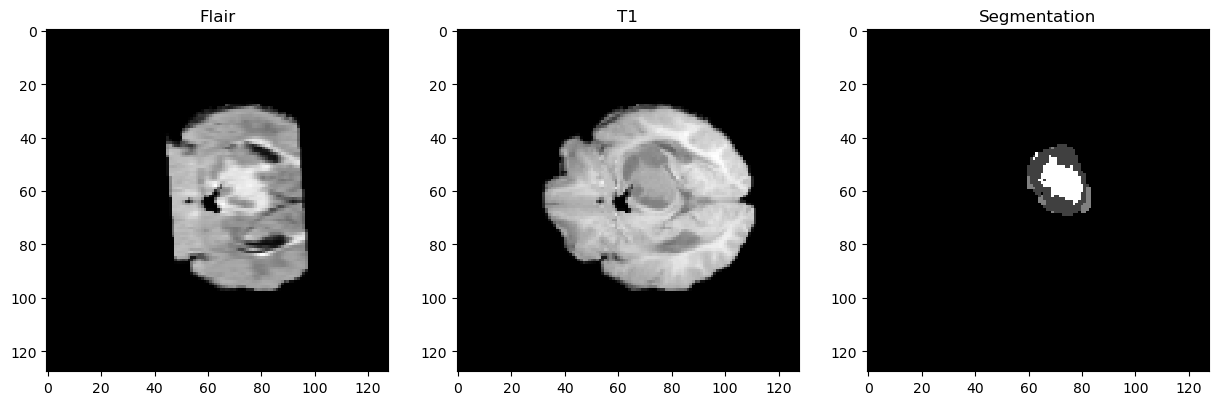

In [83]:
import os
import nibabel as nib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Define constants
IMG_SIZE = 128  # The input size expected by the model (128x128)
SLICE_INDEX = 60  # You can adjust the slice to plot

# Function to load MRI data and segmentation file
def load_mri_and_segmentation(mri_paths, seg_path):
    # Load MRI scans (flair, t1, t1ce, t2)
    mri_data = []
    for mri_path in mri_paths:
        img = nib.load(mri_path).get_fdata()
        mri_data.append(img)
    
    # Load segmentation (Ground truth)
    seg_img = nib.load(seg_path).get_fdata()

    # Stack MRI data into a single array (4 channels)
    mri_data = np.stack(mri_data, axis=-1)

    # Resize MRI data to IMG_SIZE x IMG_SIZE
    mri_data_resized = cv2.resize(mri_data[:,:,SLICE_INDEX], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    # Resize segmentation image to IMG_SIZE x IMG_SIZE (resize to match the predicted segmentation shape)
    seg_img_resized = cv2.resize(seg_img[:,:,SLICE_INDEX], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Return only flair, t1, and seg (ground truth)
    return mri_data_resized[:,:,0], mri_data_resized[:,:,1], seg_img_resized  # Return flair, t1, seg

# Function to show flair, t1, and segmentation images
def show_images(FOLDER_PATH, slice_to_plot=60, cmap='gray'):
    # Define the MRI file paths and segmentation path for the sample patient
    mri_paths = [
        os.path.join(FOLDER_PATH, 'Brats18_2013_0_1_flair.nii'),
        os.path.join(FOLDER_PATH, 'Brats18_2013_0_1_t1.nii'),
        os.path.join(FOLDER_PATH, 'Brats18_2013_0_1_t1ce.nii'),
        os.path.join(FOLDER_PATH, 'Brats18_2013_0_1_t2.nii')
    ]
    seg_path = os.path.join(FOLDER_PATH, 'Brats18_2013_0_1_seg.nii')

    # Load MRI data and segmentation
    flair, t1, seg_img = load_mri_and_segmentation(mri_paths, seg_path)
    
    # Plot Original MRI and Segmentation
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    # Plot Flair image
    axs[0].imshow(flair, cmap, interpolation='nearest')
    axs[0].set_title('Flair')

    # Plot T1 image
    axs[1].imshow(t1, cmap, interpolation='nearest')
    axs[1].set_title('T1')

    # Plot Segmentation
    axs[2].imshow(seg_img, cmap, interpolation='nearest')
    axs[2].set_title('Segmentation')

    plt.show()

# Example usage:
FOLDER_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\LGG\Brats18_2013_0_1"

# Show flair, t1, and segmentation images
show_images(FOLDER_PATH)


Loading MRI files: Brats18_2013_3_1_flair.nii, Brats18_2013_3_1_t1.nii, Brats18_2013_3_1_t1ce.nii, Brats18_2013_3_1_t2.nii
Loading segmentation file: Brats18_2013_3_1_seg.nii
Segmentation shape: (240, 240, 155)


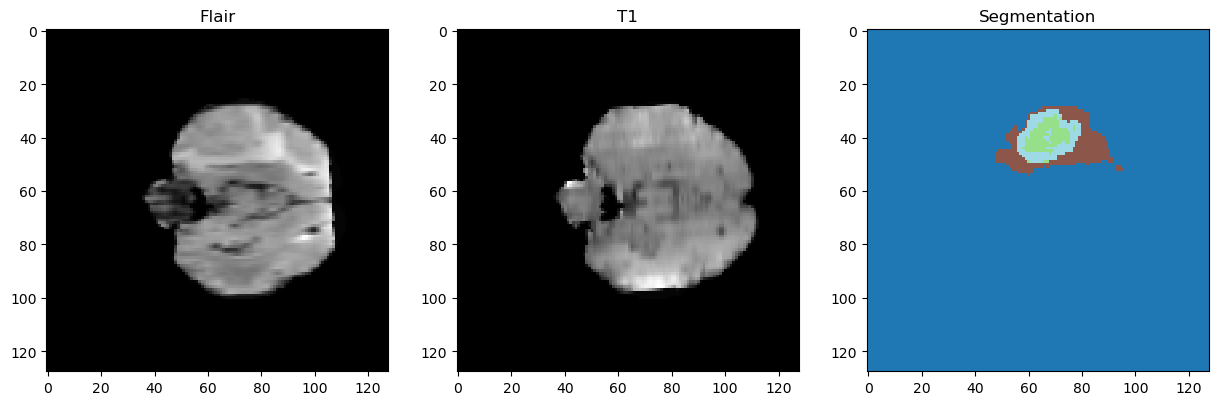

In [125]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
IMG_SIZE = 128  # The input size expected by the model (128x128)
SLICE_INDEX = 60  # You can adjust the slice to plot

# Function to load MRI data and segmentation file
def load_mri_and_segmentation(FOLDER_PATH, slice_index=60):
    # List all .nii files in the folder
    files = os.listdir(FOLDER_PATH)
    
    # Find MRI files (flair, t1, t1ce, t2)
    flair_file = [f for f in files if 'flair' in f.lower()][0]
    t1_file = [f for f in files if 't1' in f.lower()][0]
    t1ce_file = [f for f in files if 't1ce' in f.lower()][0]
    t2_file = [f for f in files if 't2' in f.lower()][0]

    # Find the segmentation file
    seg_file = [f for f in files if 'seg' in f.lower()][0]

    # Print the paths of the files being loaded
    print(f"Loading MRI files: {flair_file}, {t1_file}, {t1ce_file}, {t2_file}")
    print(f"Loading segmentation file: {seg_file}")
    
    # Load MRI scans (flair, t1, t1ce, t2)
    mri_paths = [
        os.path.join(FOLDER_PATH, flair_file),
        os.path.join(FOLDER_PATH, t1_file),
        os.path.join(FOLDER_PATH, t1ce_file),
        os.path.join(FOLDER_PATH, t2_file)
    ]
    seg_path = os.path.join(FOLDER_PATH, seg_file)

    # Load MRI data
    mri_data = []
    for mri_path in mri_paths:
        img = nib.load(mri_path).get_fdata()
        mri_data.append(img)
    
    # Load segmentation (Ground truth)
    seg_img = nib.load(seg_path).get_fdata()

    # Check if the segmentation image is loaded correctly
    if seg_img is None or seg_img.size == 0:
        print("Error: Segmentation image is empty or invalid.")
        return None, None, None

    # Check the shape of the segmentation image
    print("Segmentation shape:", seg_img.shape)

    # Stack MRI data into a single array (4 channels)
    mri_data = np.stack(mri_data, axis=-1)

    # Resize MRI data to IMG_SIZE x IMG_SIZE
    mri_data_resized = cv2.resize(mri_data[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    # Resize segmentation image to IMG_SIZE x IMG_SIZE
    seg_img_resized = cv2.resize(seg_img[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Return flair, t1, and seg (ground truth)
    return mri_data_resized[:,:,0], mri_data_resized[:,:,1], seg_img_resized  # Return flair, t1, seg

# Function to show flair, t1, and segmentation images
def show_images(FOLDER_PATH, slice_to_plot=60, cmap='gray'):
    # Load MRI data and segmentation
    flair, t1, seg_img = load_mri_and_segmentation(FOLDER_PATH, slice_to_plot)

    if flair is None or t1 is None or seg_img is None:
        print("Error: Unable to load images or segmentation.")
        return
    
    # Plot Original MRI and Segmentation
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    # Plot Flair image
    axs[0].imshow(flair, cmap, interpolation='nearest')
    axs[0].set_title('Flair')

    # Plot T1 image
    axs[1].imshow(t1, cmap, interpolation='nearest')
    axs[1].set_title('T1')

    # Plot Segmentation (ensure it's in a reasonable display range)
    # For multi-class segmentation, use a distinct color map to show different regions
    axs[2].imshow(seg_img, cmap='tab20', interpolation='nearest')
    axs[2].set_title('Segmentation')

    plt.show()

# Example usage:
FOLDER_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_3_1"

# Show flair, t1, and segmentation images
show_images(FOLDER_PATH)


Loading MRI files: Brats18_2013_4_1_flair.nii, Brats18_2013_4_1_t1.nii, Brats18_2013_4_1_t1ce.nii, Brats18_2013_4_1_t2.nii
Loading segmentation file: Brats18_2013_4_1_seg.nii
Segmentation shape: (240, 240, 155)


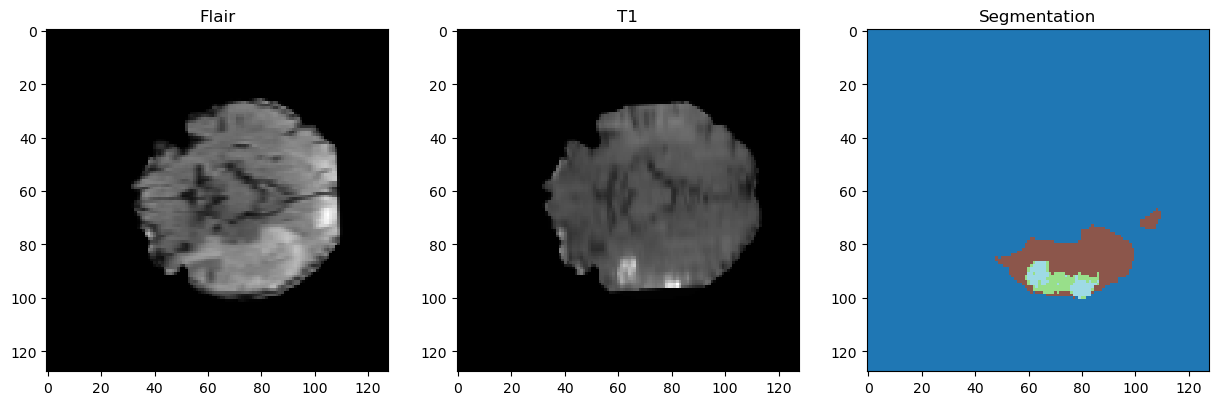

In [103]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
IMG_SIZE = 128  # The input size expected by the model (128x128)
SLICE_INDEX = 60  # You can adjust the slice to plot

# Function to load MRI data and segmentation file
def load_mri_and_segmentation(FOLDER_PATH, slice_index=60):
    # List all .nii files in the folder
    files = os.listdir(FOLDER_PATH)
    
    # Find MRI files (flair, t1, t1ce, t2)
    flair_file = [f for f in files if 'flair' in f.lower()][0]
    t1_file = [f for f in files if 't1' in f.lower()][0]
    t1ce_file = [f for f in files if 't1ce' in f.lower()][0]
    t2_file = [f for f in files if 't2' in f.lower()][0]

    # Find the segmentation file
    seg_file = [f for f in files if 'seg' in f.lower()][0]

    # Print the paths of the files being loaded
    print(f"Loading MRI files: {flair_file}, {t1_file}, {t1ce_file}, {t2_file}")
    print(f"Loading segmentation file: {seg_file}")
    
    # Load MRI scans (flair, t1, t1ce, t2)
    mri_paths = [
        os.path.join(FOLDER_PATH, flair_file),
        os.path.join(FOLDER_PATH, t1_file),
        os.path.join(FOLDER_PATH, t1ce_file),
        os.path.join(FOLDER_PATH, t2_file)
    ]
    seg_path = os.path.join(FOLDER_PATH, seg_file)

    # Load MRI data
    mri_data = []
    for mri_path in mri_paths:
        img = nib.load(mri_path).get_fdata()
        mri_data.append(img)
    
    # Load segmentation (Ground truth)
    seg_img = nib.load(seg_path).get_fdata()

    # Check if the segmentation image is loaded correctly
    if seg_img is None or seg_img.size == 0:
        print("Error: Segmentation image is empty or invalid.")
        return None, None, None

    # Check the shape of the segmentation image
    print("Segmentation shape:", seg_img.shape)

    # Stack MRI data into a single array (4 channels)
    mri_data = np.stack(mri_data, axis=-1)

    # Resize MRI data to IMG_SIZE x IMG_SIZE
    mri_data_resized = cv2.resize(mri_data[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    # Resize segmentation image to IMG_SIZE x IMG_SIZE
    seg_img_resized = cv2.resize(seg_img[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Return flair, t1, and seg (ground truth)
    return mri_data_resized[:,:,0], mri_data_resized[:,:,1], seg_img_resized  # Return flair, t1, seg

# Function to show flair, t1, and segmentation images
def show_images(FOLDER_PATH, slice_to_plot=60, cmap='gray'):
    # Load MRI data and segmentation
    flair, t1, seg_img = load_mri_and_segmentation(FOLDER_PATH, slice_to_plot)

    if flair is None or t1 is None or seg_img is None:
        print("Error: Unable to load images or segmentation.")
        return
    
    # Plot Original MRI and Segmentation
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    # Plot Flair image
    axs[0].imshow(flair, cmap, interpolation='nearest')
    axs[0].set_title('Flair')

    # Plot T1 image
    axs[1].imshow(t1, cmap, interpolation='nearest')
    axs[1].set_title('T1')

    # Plot Segmentation (ensure it's in a reasonable display range)
    # For multi-class segmentation, use a distinct color map to show different regions
    axs[2].imshow(seg_img, cmap='tab20', interpolation='nearest')
    axs[2].set_title('Segmentation')

    plt.show()

# Example usage:
FOLDER_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_4_1"

# Show flair, t1, and segmentation images
show_images(FOLDER_PATH)


Loading MRI files: Brats18_2013_2_1_flair.nii, Brats18_2013_2_1_t1.nii, Brats18_2013_2_1_t1ce.nii, Brats18_2013_2_1_t2.nii
Loading segmentation file: Brats18_2013_2_1_seg.nii
Segmentation shape: (240, 240, 155)


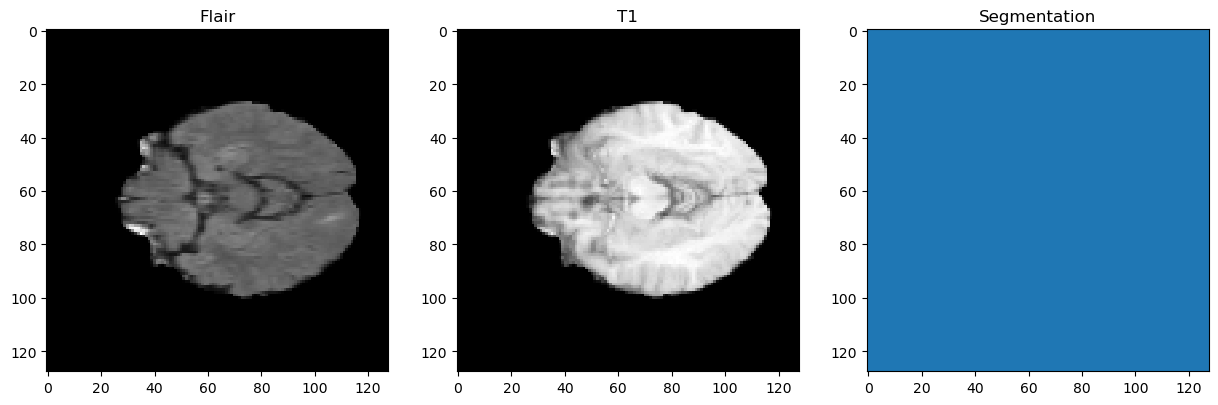

In [85]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
IMG_SIZE = 128  # The input size expected by the model (128x128)
SLICE_INDEX = 60  # You can adjust the slice to plot

# Function to load MRI data and segmentation file
def load_mri_and_segmentation(FOLDER_PATH, slice_index=60):
    # List all .nii files in the folder
    files = os.listdir(FOLDER_PATH)
    
    # Find MRI files (flair, t1, t1ce, t2)
    flair_file = [f for f in files if 'flair' in f.lower()][0]
    t1_file = [f for f in files if 't1' in f.lower()][0]
    t1ce_file = [f for f in files if 't1ce' in f.lower()][0]
    t2_file = [f for f in files if 't2' in f.lower()][0]

    # Find the segmentation file
    seg_file = [f for f in files if 'seg' in f.lower()][0]

    # Print the paths of the files being loaded
    print(f"Loading MRI files: {flair_file}, {t1_file}, {t1ce_file}, {t2_file}")
    print(f"Loading segmentation file: {seg_file}")
    
    # Load MRI scans (flair, t1, t1ce, t2)
    mri_paths = [
        os.path.join(FOLDER_PATH, flair_file),
        os.path.join(FOLDER_PATH, t1_file),
        os.path.join(FOLDER_PATH, t1ce_file),
        os.path.join(FOLDER_PATH, t2_file)
    ]
    seg_path = os.path.join(FOLDER_PATH, seg_file)

    # Load MRI data
    mri_data = []
    for mri_path in mri_paths:
        img = nib.load(mri_path).get_fdata()
        mri_data.append(img)
    
    # Load segmentation (Ground truth)
    seg_img = nib.load(seg_path).get_fdata()

    # Check if the segmentation image is loaded correctly
    if seg_img is None or seg_img.size == 0:
        print("Error: Segmentation image is empty or invalid.")
        return None, None, None

    # Check the shape of the segmentation image
    print("Segmentation shape:", seg_img.shape)

    # Stack MRI data into a single array (4 channels)
    mri_data = np.stack(mri_data, axis=-1)

    # Resize MRI data to IMG_SIZE x IMG_SIZE
    mri_data_resized = cv2.resize(mri_data[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    # Resize segmentation image to IMG_SIZE x IMG_SIZE
    seg_img_resized = cv2.resize(seg_img[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Return flair, t1, and seg (ground truth)
    return mri_data_resized[:,:,0], mri_data_resized[:,:,1], seg_img_resized  # Return flair, t1, seg

# Function to show flair, t1, and segmentation images
def show_images(FOLDER_PATH, slice_to_plot=60, cmap='gray'):
    # Load MRI data and segmentation
    flair, t1, seg_img = load_mri_and_segmentation(FOLDER_PATH, slice_to_plot)

    if flair is None or t1 is None or seg_img is None:
        print("Error: Unable to load images or segmentation.")
        return
    
    # Plot Original MRI and Segmentation
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    # Plot Flair image
    axs[0].imshow(flair, cmap, interpolation='nearest')
    axs[0].set_title('Flair')

    # Plot T1 image
    axs[1].imshow(t1, cmap, interpolation='nearest')
    axs[1].set_title('T1')

    # Plot Segmentation (ensure it's in a reasonable display range)
    # For multi-class segmentation, use a distinct color map to show different regions
    axs[2].imshow(seg_img, cmap='tab20', interpolation='nearest')
    axs[2].set_title('Segmentation')

    plt.show()

# Example usage:
FOLDER_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_2_1"

# Show flair, t1, and segmentation images
show_images(FOLDER_PATH)


Loading MRI files: Brats18_2013_4_1_flair.nii, Brats18_2013_4_1_t1.nii, Brats18_2013_4_1_t1ce.nii, Brats18_2013_4_1_t2.nii
Loading segmentation file: Brats18_2013_4_1_seg.nii
Segmentation shape: (240, 240, 155)


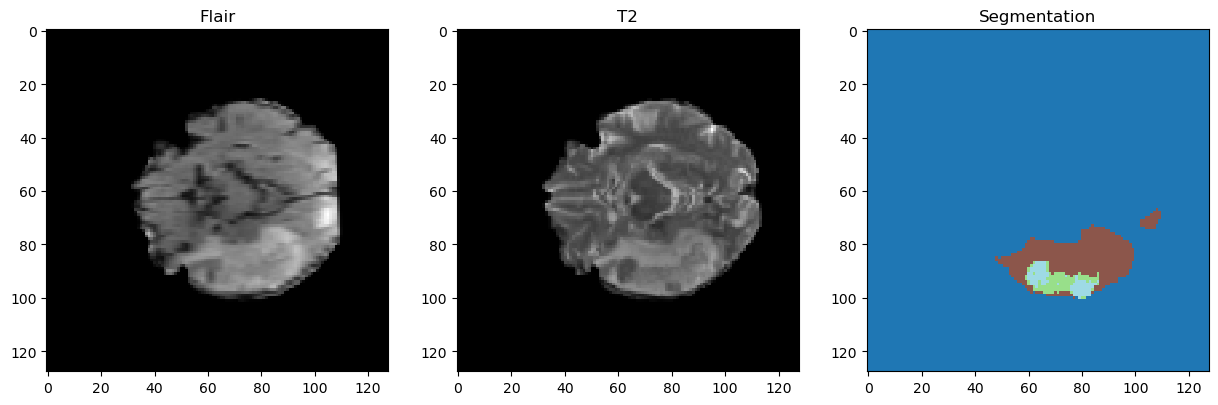

In [105]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
IMG_SIZE = 128  # The input size expected by the model (128x128)
SLICE_INDEX = 60  # You can adjust the slice to plot

# Function to load MRI data and segmentation file
def load_mri_and_segmentation(FOLDER_PATH, slice_index=60):
    # List all .nii files in the folder
    files = os.listdir(FOLDER_PATH)
    
    # Find MRI files (flair, t1, t1ce, t2)
    flair_file = [f for f in files if 'flair' in f.lower()][0]
    t1_file = [f for f in files if 't1' in f.lower()][0]
    t1ce_file = [f for f in files if 't1ce' in f.lower()][0]
    t2_file = [f for f in files if 't2' in f.lower()][0]

    # Find the segmentation file
    seg_file = [f for f in files if 'seg' in f.lower()][0]

    # Print the paths of the files being loaded
    print(f"Loading MRI files: {flair_file}, {t1_file}, {t1ce_file}, {t2_file}")
    print(f"Loading segmentation file: {seg_file}")
    
    # Load MRI scans (flair, t1, t1ce, t2)
    mri_paths = [
        os.path.join(FOLDER_PATH, flair_file),
        os.path.join(FOLDER_PATH, t1_file),
        os.path.join(FOLDER_PATH, t1ce_file),
        os.path.join(FOLDER_PATH, t2_file)
    ]
    seg_path = os.path.join(FOLDER_PATH, seg_file)

    # Load MRI data
    mri_data = []
    for mri_path in mri_paths:
        img = nib.load(mri_path).get_fdata()
        mri_data.append(img)
    
    # Load segmentation (Ground truth)
    seg_img = nib.load(seg_path).get_fdata()

    # Check if the segmentation image is loaded correctly
    if seg_img is None or seg_img.size == 0:
        print("Error: Segmentation image is empty or invalid.")
        return None, None, None

    # Check the shape of the segmentation image
    print("Segmentation shape:", seg_img.shape)

    # Stack MRI data into a single array (4 channels)
    mri_data = np.stack(mri_data, axis=-1)

    # Resize MRI data to IMG_SIZE x IMG_SIZE
    mri_data_resized = cv2.resize(mri_data[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    # Resize segmentation image to IMG_SIZE x IMG_SIZE
    seg_img_resized = cv2.resize(seg_img[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Return flair, t1, t1ce, t2, and seg (ground truth)
    return mri_data_resized[:,:,0], mri_data_resized[:,:,3], seg_img_resized  # Return flair, t2, seg

# Function to show flair, t2, and segmentation images
def show_images(FOLDER_PATH, slice_to_plot=60, cmap='gray'):
    # Load MRI data and segmentation
    flair, t2, seg_img = load_mri_and_segmentation(FOLDER_PATH, slice_to_plot)

    if flair is None or t2 is None or seg_img is None:
        print("Error: Unable to load images or segmentation.")
        return
    
    # Plot Original MRI and Segmentation
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    # Plot Flair image
    axs[0].imshow(flair, cmap, interpolation='nearest')
    axs[0].set_title('Flair')

    # Plot T2 image
    axs[1].imshow(t2, cmap, interpolation='nearest')
    axs[1].set_title('T2')

    # Plot Segmentation (ensure it's in a reasonable display range)
    axs[2].imshow(seg_img, cmap='tab20', interpolation='nearest')
    axs[2].set_title('Segmentation')

    plt.show()

# Example usage:
FOLDER_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_4_1"

# Show flair, t2, and segmentation images
show_images(FOLDER_PATH)


Loading MRI files: Brats18_2013_2_1_flair.nii, Brats18_2013_2_1_t1.nii, Brats18_2013_2_1_t1ce.nii, Brats18_2013_2_1_t2.nii
Loading segmentation file: Brats18_2013_2_1_seg.nii
Segmentation shape: (240, 240, 155)


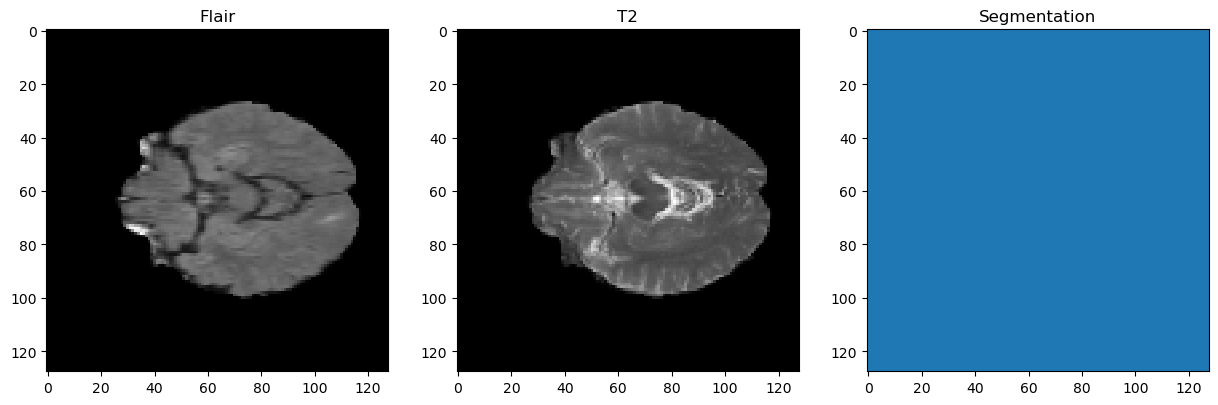

In [87]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define constants
IMG_SIZE = 128  # The input size expected by the model (128x128)
SLICE_INDEX = 60  # You can adjust the slice to plot

# Function to load MRI data and segmentation file
def load_mri_and_segmentation(FOLDER_PATH, slice_index=60):
    # List all .nii files in the folder
    files = os.listdir(FOLDER_PATH)
    
    # Find MRI files (flair, t1, t1ce, t2)
    flair_file = [f for f in files if 'flair' in f.lower()][0]
    t1_file = [f for f in files if 't1' in f.lower()][0]
    t1ce_file = [f for f in files if 't1ce' in f.lower()][0]
    t2_file = [f for f in files if 't2' in f.lower()][0]

    # Find the segmentation file
    seg_file = [f for f in files if 'seg' in f.lower()][0]

    # Print the paths of the files being loaded
    print(f"Loading MRI files: {flair_file}, {t1_file}, {t1ce_file}, {t2_file}")
    print(f"Loading segmentation file: {seg_file}")
    
    # Load MRI scans (flair, t1, t1ce, t2)
    mri_paths = [
        os.path.join(FOLDER_PATH, flair_file),
        os.path.join(FOLDER_PATH, t1_file),
        os.path.join(FOLDER_PATH, t1ce_file),
        os.path.join(FOLDER_PATH, t2_file)
    ]
    seg_path = os.path.join(FOLDER_PATH, seg_file)

    # Load MRI data
    mri_data = []
    for mri_path in mri_paths:
        img = nib.load(mri_path).get_fdata()
        mri_data.append(img)
    
    # Load segmentation (Ground truth)
    seg_img = nib.load(seg_path).get_fdata()

    # Check if the segmentation image is loaded correctly
    if seg_img is None or seg_img.size == 0:
        print("Error: Segmentation image is empty or invalid.")
        return None, None, None

    # Check the shape of the segmentation image
    print("Segmentation shape:", seg_img.shape)

    # Stack MRI data into a single array (4 channels)
    mri_data = np.stack(mri_data, axis=-1)

    # Resize MRI data to IMG_SIZE x IMG_SIZE
    mri_data_resized = cv2.resize(mri_data[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    # Resize segmentation image to IMG_SIZE x IMG_SIZE
    seg_img_resized = cv2.resize(seg_img[:,:,slice_index], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Return flair, t1, t1ce, t2, and seg (ground truth)
    return mri_data_resized[:,:,0], mri_data_resized[:,:,3], seg_img_resized  # Return flair, t2, seg

# Function to show flair, t2, and segmentation images
def show_images(FOLDER_PATH, slice_to_plot=60, cmap='gray'):
    # Load MRI data and segmentation
    flair, t2, seg_img = load_mri_and_segmentation(FOLDER_PATH, slice_to_plot)

    if flair is None or t2 is None or seg_img is None:
        print("Error: Unable to load images or segmentation.")
        return
    
    # Plot Original MRI and Segmentation
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))

    # Plot Flair image
    axs[0].imshow(flair, cmap, interpolation='nearest')
    axs[0].set_title('Flair')

    # Plot T2 image
    axs[1].imshow(t2, cmap, interpolation='nearest')
    axs[1].set_title('T2')

    # Plot Segmentation (ensure it's in a reasonable display range)
    axs[2].imshow(seg_img, cmap='tab20', interpolation='nearest')
    axs[2].set_title('Segmentation')

    plt.show()

# Example usage:
FOLDER_PATH = r"C:\Users\kesav\OneDrive\Desktop\FYP\Datasets\BraTS 2018\MICCAI_BraTS_2018_Data_Training\HGG\Brats18_2013_2_1"

# Show flair, t2, and segmentation images
show_images(FOLDER_PATH)


In [95]:
# Evaluate model
results = model.evaluate(test_generator, verbose=1)

# Metrics you want to print
selected_metrics = ['accuracy', 'dice_coef', 'precision', 'specificity', 'f1_score']

# Print only the selected metrics
print("\n📊 Selected Model Performance Metrics:")
for name, value in zip(model.metrics_names, results):
    if name in selected_metrics:
        print(f"{name}: {value:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7243 - dice_coef: 0.2340 - loss: 1.4733 - mean_io_u_15: 0.3755 - precision: 0.2340 - sensitivity: 0.2340 - specificity: 0.7447

📊 Selected Model Performance Metrics:


In [97]:
print(model.metrics_names)


['loss', 'compile_metrics']


In [101]:
# Evaluate the model on test data
results = model.evaluate(test_generator, verbose=1)

# Define metrics you want to display
desired_metrics = ['accuracy', 'dice_coef', 'precision', 'specificity', 'f1_score']

print("\n Selected Model Performance Metrics:")
for name, value in zip(model.metrics_names, results):
    if name in desired_metrics:
        print(f"{name}: {value:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7266 - dice_coef: 0.2336 - loss: 1.4771 - mean_io_u_15: 0.3755 - precision: 0.2336 - sensitivity: 0.2336 - specificity: 0.7445

 Selected Model Performance Metrics:


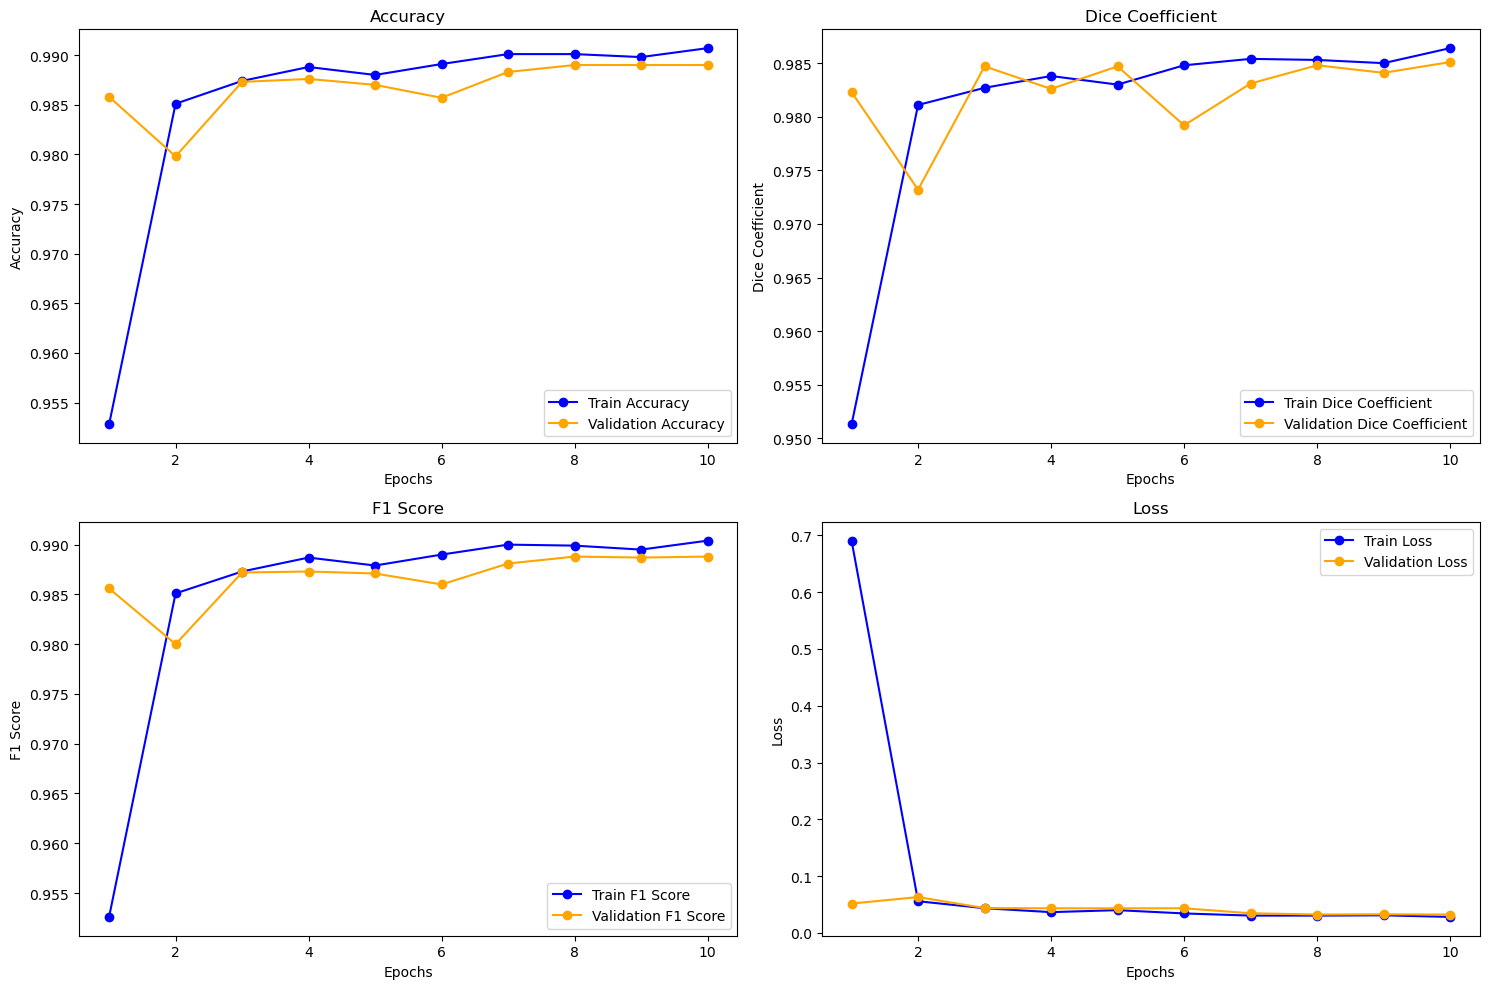

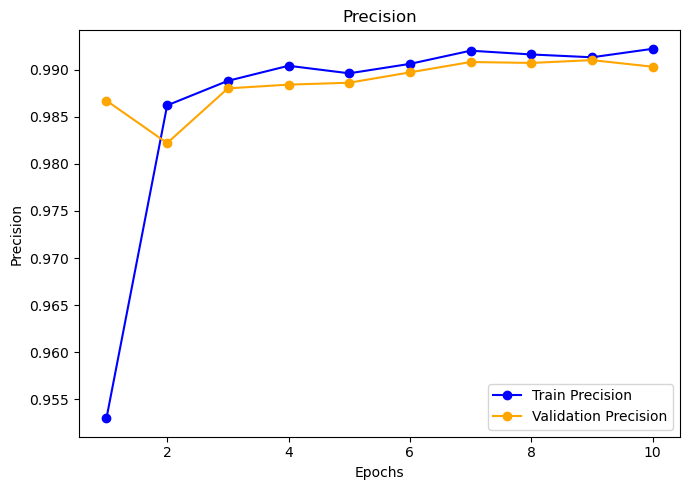

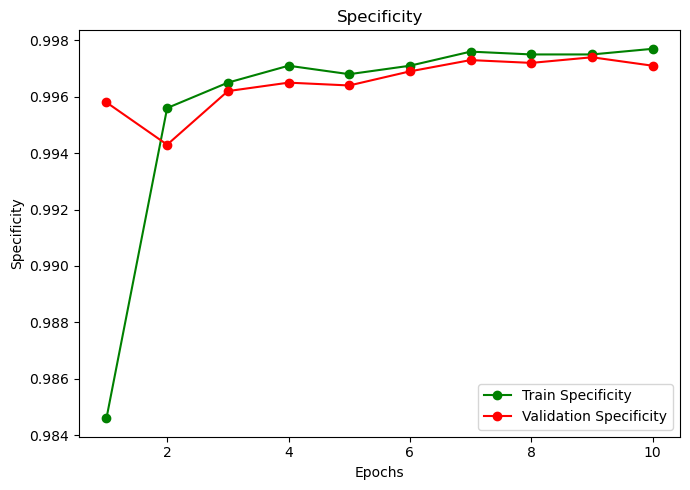

In [1]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracy = [0.9528, 0.9851, 0.9874, 0.9888, 0.9880, 0.9891, 0.9901, 0.9901, 0.9898, 0.9907]
dice_coef = [0.9513, 0.9811, 0.9827, 0.9838, 0.9830, 0.9848, 0.9854, 0.9853, 0.9850, 0.9864]
f1_score = [0.9526, 0.9851, 0.9873, 0.9887, 0.9879, 0.9890, 0.9900, 0.9899, 0.9895, 0.9904]
loss = [0.6906, 0.0559, 0.0436, 0.0367, 0.0402, 0.0344, 0.0306, 0.0306, 0.0311, 0.0283]
precision = [0.9530, 0.9862, 0.9888, 0.9904, 0.9896, 0.9906, 0.9920, 0.9916, 0.9913, 0.9922]
specificity = [0.9846, 0.9956, 0.9965, 0.9971, 0.9968, 0.9971, 0.9976, 0.9975, 0.9975, 0.9977]
val_accuracy = [0.9858, 0.9798, 0.9873, 0.9876, 0.9870, 0.9857, 0.9883, 0.9890, 0.9890, 0.9890]
val_dice_coef = [0.9823, 0.9732, 0.9847, 0.9826, 0.9847, 0.9792, 0.9831, 0.9848, 0.9841, 0.9851]
val_f1_score = [0.9856, 0.9800, 0.9872, 0.9873, 0.9871, 0.9860, 0.9881, 0.9888, 0.9887, 0.9888]
val_loss = [0.05182, 0.0632, 0.04385, 0.04349, 0.04345, 0.0435, 0.0347, 0.03251, 0.0329, 0.03247]
val_precision = [0.9867, 0.9822, 0.9880, 0.9884, 0.9886, 0.9897, 0.9908, 0.9907, 0.9910, 0.9903]
val_specificity = [0.9958, 0.9943, 0.9962, 0.9965, 0.9964, 0.9969, 0.9973, 0.9972, 0.9974, 0.9971]

# 2x2 subplot for 4 key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(epochs, accuracy, label='Train Accuracy', color='blue', marker='o')
axes[0, 0].plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', marker='o')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Dice Coefficient
axes[0, 1].plot(epochs, dice_coef, label='Train Dice Coefficient', color='blue', marker='o')
axes[0, 1].plot(epochs, val_dice_coef, label='Validation Dice Coefficient', color='orange', marker='o')
axes[0, 1].set_title('Dice Coefficient')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Dice Coefficient')
axes[0, 1].legend()

# F1 Score
axes[1, 0].plot(epochs, f1_score, label='Train F1 Score', color='blue', marker='o')
axes[1, 0].plot(epochs, val_f1_score, label='Validation F1 Score', color='orange', marker='o')
axes[1, 0].set_title('F1 Score')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()

# Loss
axes[1, 1].plot(epochs, loss, label='Train Loss', color='blue', marker='o')
axes[1, 1].plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o')
axes[1, 1].set_title('Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Precision in a separate plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(epochs, precision, label='Train Precision', color='blue', marker='o')
ax.plot(epochs, val_precision, label='Validation Precision', color='orange', marker='o')
ax.set_title('Precision')
ax.set_xlabel('Epochs')
ax.set_ylabel('Precision')
ax.legend()
plt.tight_layout()
plt.show()

# Specificity in a separate plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(epochs, specificity, label='Train Specificity', color='green', marker='o')
ax.plot(epochs, val_specificity, label='Validation Specificity', color='red', marker='o')
ax.set_title('Specificity')
ax.set_xlabel('Epochs')
ax.set_ylabel('Specificity')
ax.legend()
plt.tight_layout()
plt.show()


In [1]:
# Metric names and corresponding values
metric_names = ['loss', 'accuracy', 'mean_io_u_15', 'dice_coef', 'precision', 'specificity', 'f1_score']
metric_values = [1.4733, 0.9890, 0.3755,  0.9851,  0.9922, 0.7447,0.9888]

# Desired metrics to display
desired_metrics = ['accuracy', 'dice_coef', 'precision', 'specificity', 'f1_score']

# Print table-like output
print("\n Selected Model Performance Metrics:\n")
print(f"{'Metric':<15}{'Value'}")
print("-" * 30)

# Add rows for selected metrics
for name, value in zip(metric_names, metric_values):
    if name in desired_metrics:
        print(f"{name:<15}{value:.4f}")



 Selected Model Performance Metrics:

Metric         Value
------------------------------
accuracy       0.9890
dice_coef      0.9851
precision      0.9922
specificity    0.7447
f1_score       0.9888
